In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
import pandas as pd

plt.style.use(hep.style.ROOT)

### user defined

In [28]:
### Variables used in software
baseline = 0

#cutoff between fit area for gauss and Landau
LG_cut=20
HG_cut=100
#maximum value in the histogram for LG and HG
LG_hist_max=100
HG_hist_max=2000


swap = dict({ch : ch for ch in channels})
# note that the cables for 2 and 3 were swapped in Run 14.  
# comment out these lines of code if the cables aren't swapped for the particular run,
# or add other similar lines of code to include other swaps
swap['02']='03'
swap['03']='02'

In [3]:
with open('Run14_list.txt') as f:
    lines = f.read().split('\n')
tags = None
channels =[]
din={"timestamp":[], "trigID":[]}
#din.update({f"timestamp_{unit}":[] for unit in "year month day hour minute"})
for line in lines:
    if line[:2]=="//" or len(line)==0:
        continue
    #first line after comments
    if tags is None:
        tags = line.split()
        tags=tags[-3:]
        continue
    split = line.split()
    
    if len(split)== 6:
        timestamp_us=float(split[0])
        din['timestamp'].append(timestamp_us)
        trigID=int(split[1])
        din['trigID'].append(trigID)
    
    channel, LG, HG = split[-3:]
    if channel not in channels:
        din[f"Ch_{channel}_LG"] = []
        din[f"Ch_{channel}_HG"] = []
        channels.append(channel)
    din[f"Ch_{channel}_LG"].append(float(LG)-baseline)
    din[f"Ch_{channel}_HG"].append(float(HG)-baseline)
df = pd.DataFrame(din)



print(f"Done! Total events: {len(df)}")
print(f"channels in df are:  {channels}")
#channels.remove("00")
nchannels= len(channels)

Done! Total events: 56222
channels in df are:  ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']


In [4]:
def Landau(x, normalization,location,stdev):
    #print(type(x))
    u=(x-location)*3.591/stdev/2.355
    renormalization = 1.64872*normalization
    return renormalization * np.exp(-u/2 - np.exp(-u)/2)

def Landau_integral(normalization, location, stdev):
    x=np.linspace(location-5*stdev, location+5*stdev, 100)
    y=Landau(x, normalization, location, stdev)
    return sum(y)*(x[1]-x[0])


def LandauPlusGauss(x, normalization,location,stdev, a, mu, sigma):
    u=(x-location)*3.591/stdev/2.355
    renormalization = 1.64872*normalization
    return renormalization * np.exp(-u/2 - np.exp(-u)/2)+a*np.exp(-(x-mu)**2/(2*sigma**2))

def Gauss(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

27.884248400431673
25.331202108079328
28.2101916670986
25.76586380697338
33.2768179879302
31.986573295975607
31.454555074566034
26.5662795408434
27.377678656718267
24.272774340485938
30.211792047294168
31.070178964495536
25.448204845449812
29.430635055709462
24.886766632744727
31.703072789959187
0
0.5


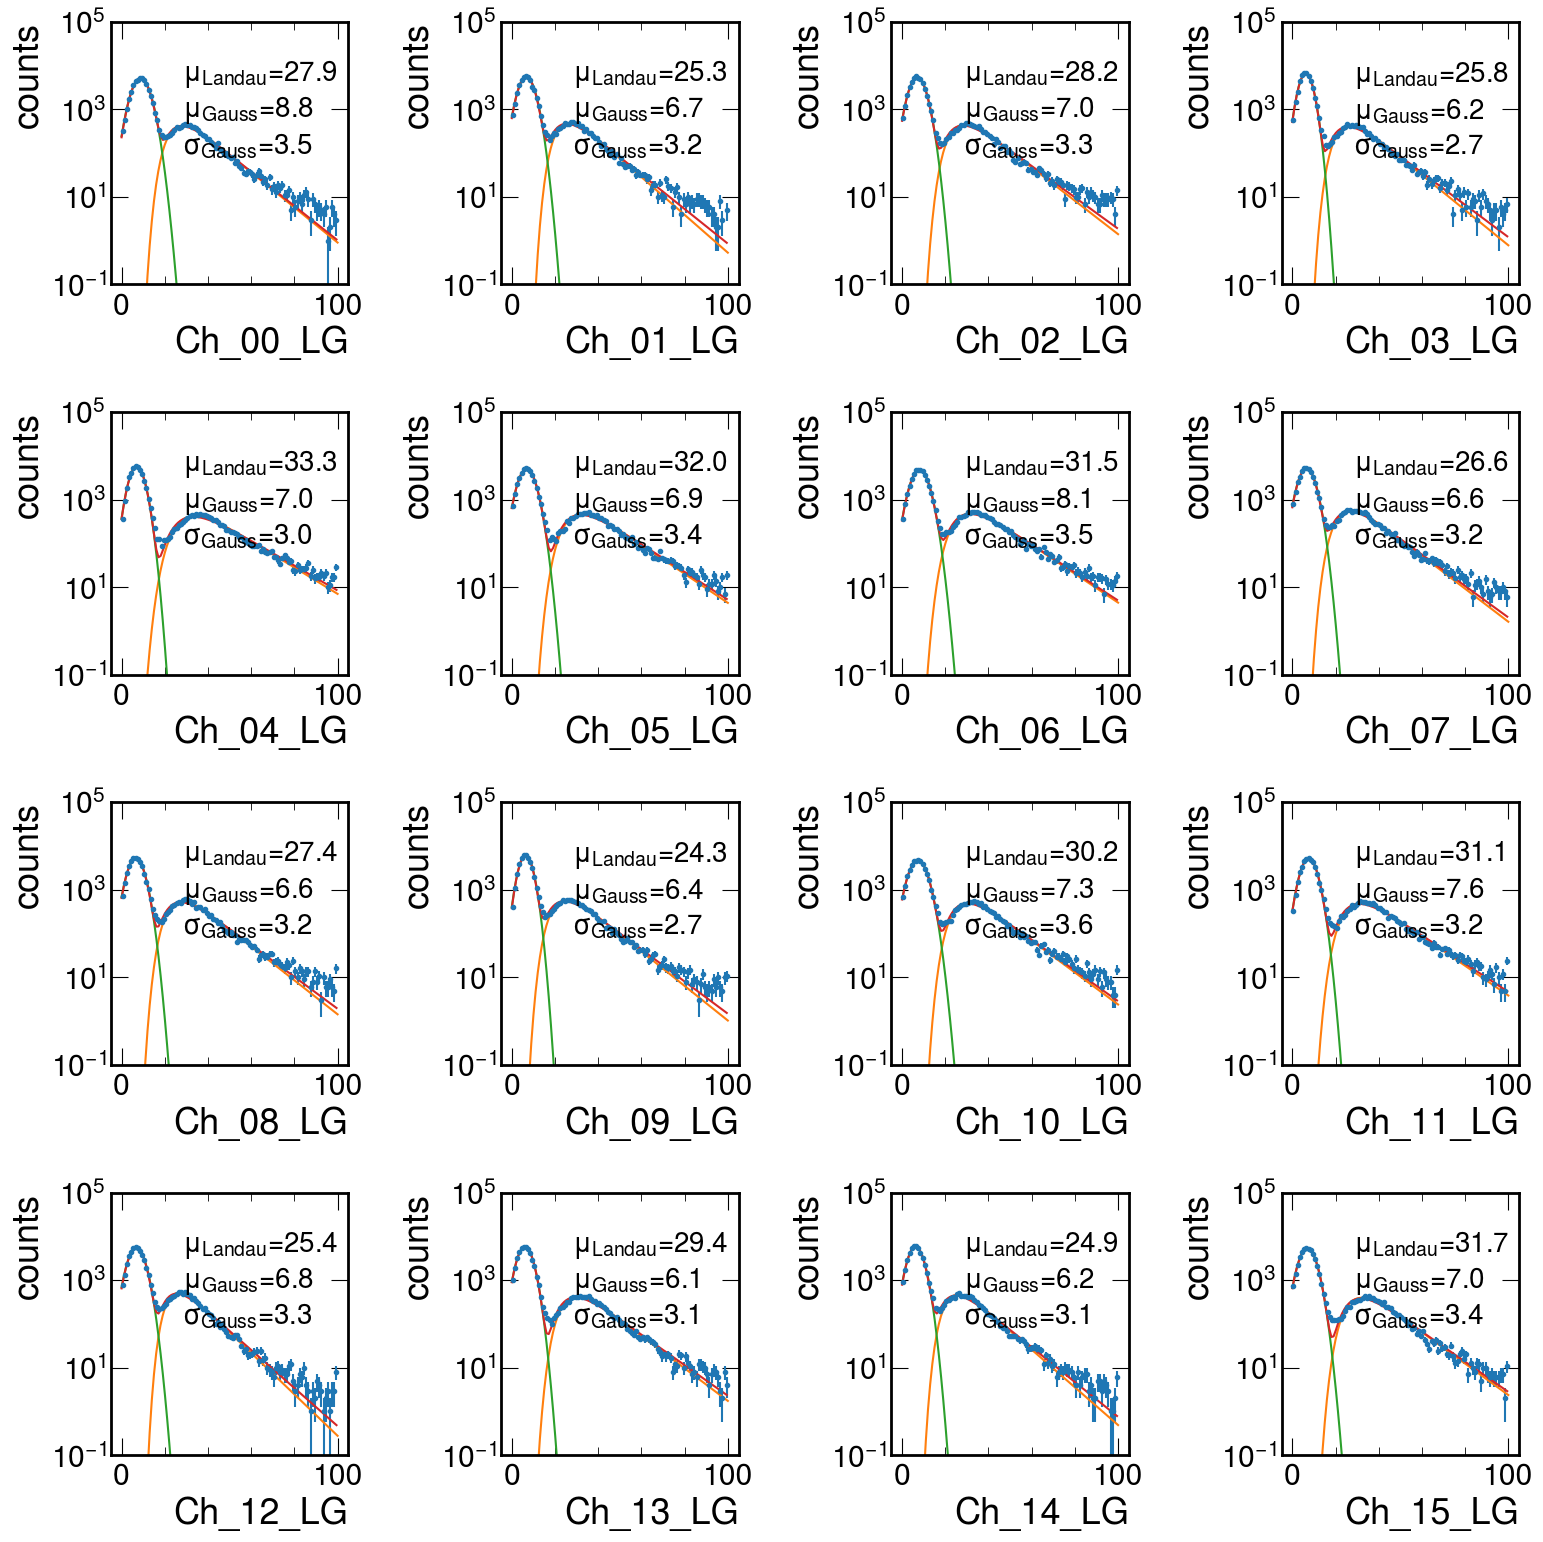

511.4788273769995
494.827861568811
567.9758405998036
547.0718413092314
708.185947557956
666.3312929938311
628.1587704959124
552.1486619123762
564.1912930258239
516.9734444074339
603.5067687696436
631.011640078808
505.5561988904297
662.4673831939256
528.235044331765
673.0488413028735
0
3.3333333333333335


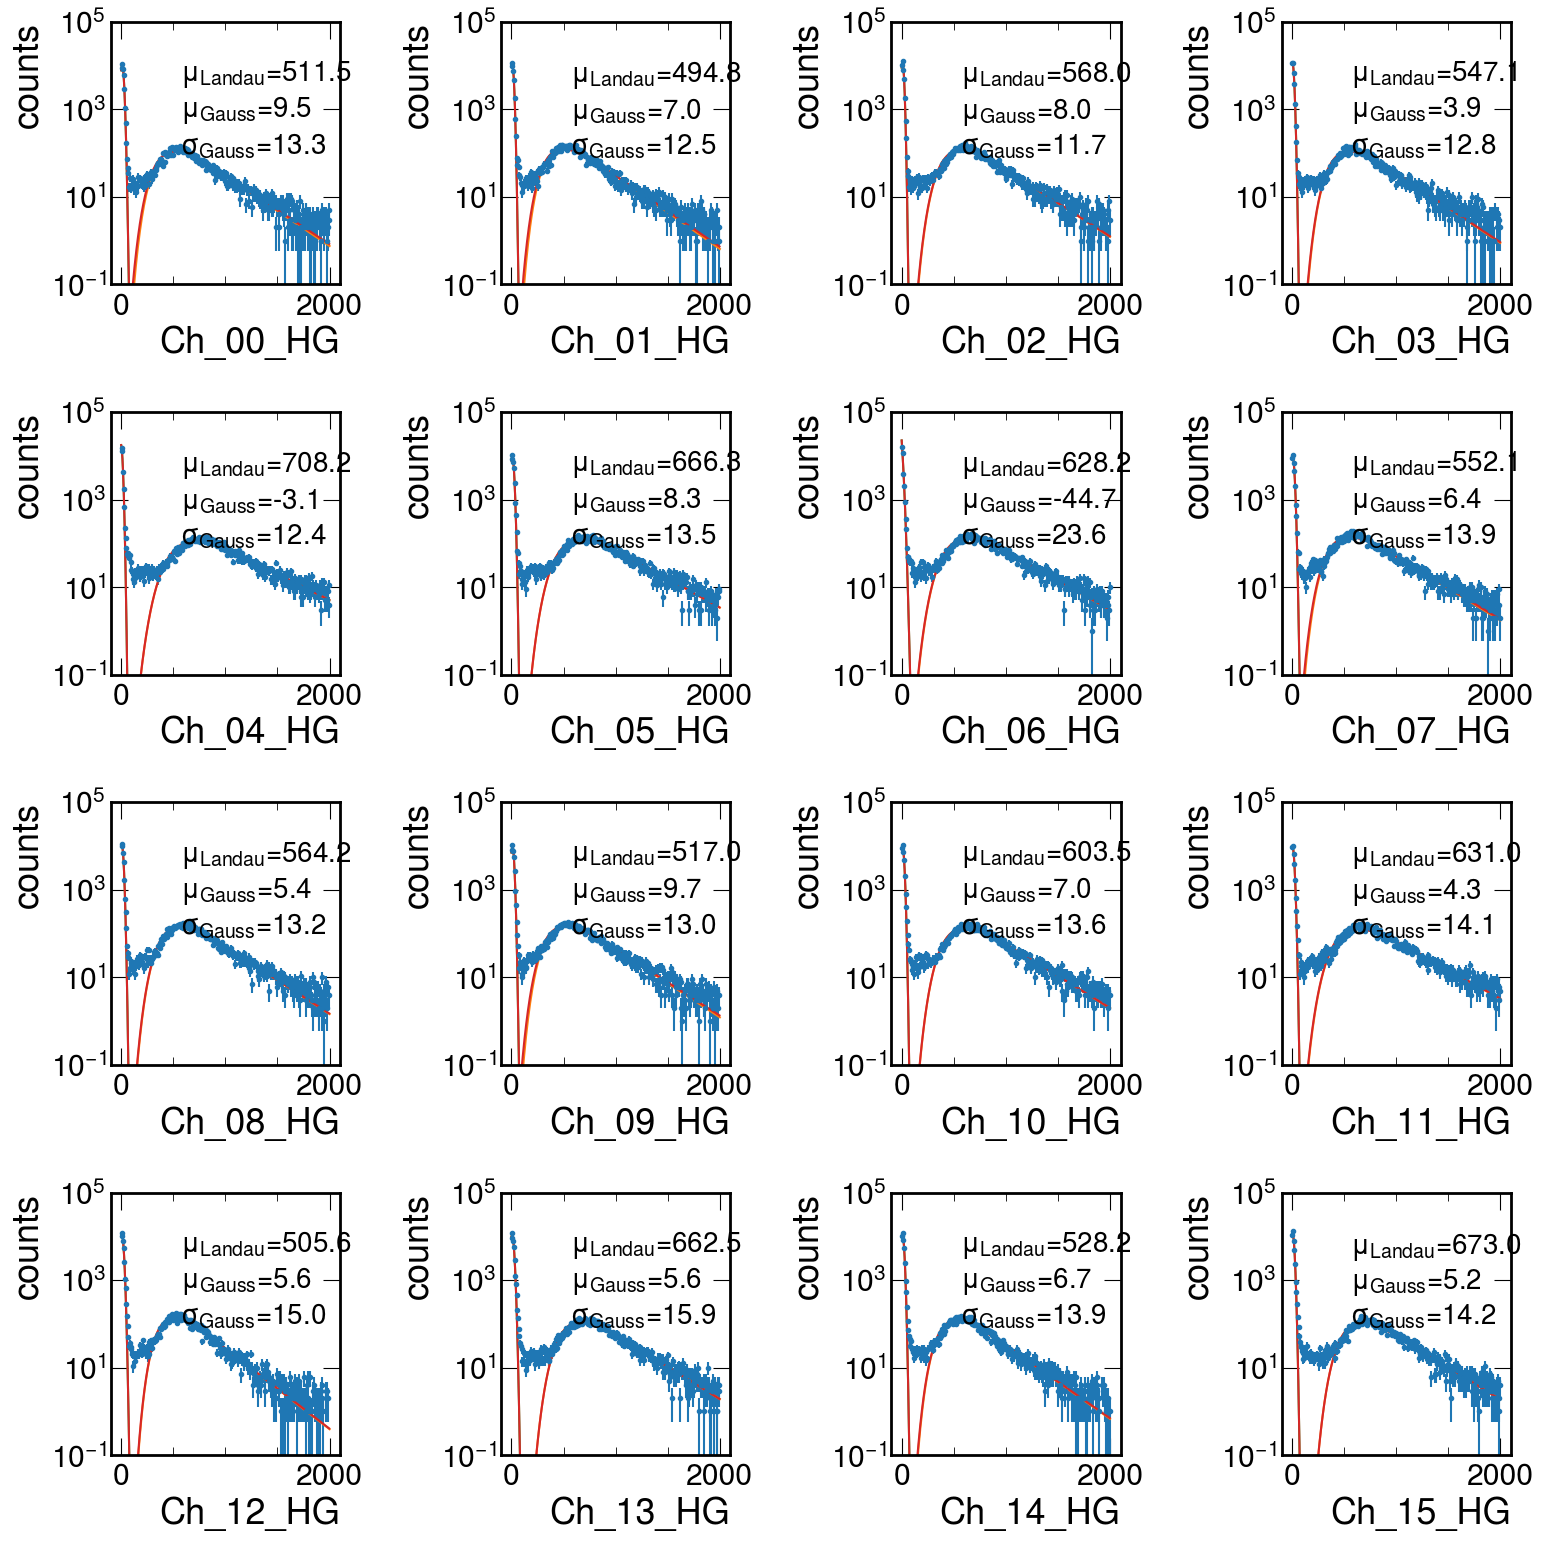

In [11]:
MIP={}
integrals={}
for gain in "LG HG".split():
    fig, axs=plt.subplots(nchannels//4, 4, figsize=(16, 1.*nchannels))
    
    for i in range(len(channels)):

        ch = channels[i]
        plt.sca(axs[i//4][i%4])
        hist,x,= np.histogram(df.eval(f"Ch_{ch}_{gain}"), bins=100 if gain== "LG" else 300, 
                              range=(0,LG_hist_max) if gain == "LG" else (0, HG_hist_max))
        xlabel=f"Ch_{ch}_{gain}"
        

        plt.xlabel(xlabel)
        plt.ylabel("counts")

        bin_centers=(x[1:]+x[:-1])/2

        from scipy.optimize import curve_fit
        if gain=="LG":
            start,stop=int(LG_cut/(x[1]-x[0])),None
        else :
            start,stop=int(200/(x[1]-x[0])),None
        p0=[1000, 30, 10] if gain=='LG' else [100, 500, 200]

        plt.yscale("log")
        plt.ylim(0.1, 1e5)
        dhist=np.sqrt(hist)+(hist==0)

        plt.errorbar(bin_centers, hist, np.sqrt(hist), linestyle='', marker='o', label='data', markersize=3)
        mu_g=999999999
        sigma_g=99999999
        try:
            coeff, var_matrix = curve_fit(Landau, bin_centers[start:stop], hist[start:stop], p0=p0,
                                 sigma=dhist[start:stop])

            curve = plt.plot(x, Landau(x,*coeff), label=f"Landau")
            from scipy.stats import chi2
            #chi2val = sum((Landau(bin_centers[start:stop], *coeff)-hist[start:stop])**2/dhist[start:stop]**2)
            #ndof = len(bin_centers[start:stop])-len(coeff)
            #print("chi2=",chi2val, "ndof=",ndof, "pval=", chi2.sf(chi2val, ndof))
            x=np.linspace(0, max(bin_centers), LG_hist_max if gain=='LG' else HG_hist_max)
            normalization=coeff[0]
            mu=coeff[1]
            sigma=coeff[2]

            try:
                if gain=="LG":
                    start, stop = 0, int(LG_cut/(bin_centers[1]-bin_centers[0]))
                else :
                    start, stop = 0, int(HG_cut/(bin_centers[1]-bin_centers[0]))
                coeff_g, var_matrix = curve_fit(Gauss, bin_centers[start:stop], hist[start:stop], p0=[10000,10,15],
                                         sigma=dhist[start:stop])
                curve = plt.plot(x, Gauss(x,*coeff_g), label=f"Gauss")



                coeff_lg, var_matrix = curve_fit(LandauPlusGauss, bin_centers, hist, p0=list(coeff)+list(coeff_g),
                                         sigma=dhist)
                curve = plt.plot(x, LandauPlusGauss(x,*coeff_lg), label=f"Landau+Gauss")
                normalization=coeff_lg[0]
                mu=coeff_lg[1]
                sigma=coeff_lg[2]
                mu_g=coeff_lg[4]
                sigma_g=abs(coeff_lg[5])
            except :
                print("warning:  failed Landau+Gauss fit.  using Landau fit only")

            scale=1
            

            if abs(mu*scale) < 1e3 and abs(mu_g*scale)<1e3 and abs(sigma_g)<1e3:
                print(mu*scale)
                plt.text(0.30, 0.5, f"$\mu_{{\\rm Landau}}$={mu*scale:.1f}\n$\mu_{{\\rm Gauss}}$={mu_g*scale:.1f}\n$\\sigma_{{\\rm Gauss}}$={sigma_g*scale:.1f}", transform=plt.gca().transAxes, fontsize=20)


            if mu <200 and gain == "HG" or mu<20 and gain=="LG" or mu> 1e3:
                raise RuntimeError(f"fitted value of mu out of bounds: {ch}_{gain}, mu={mu}")
            MIP[(ch,gain)]=mu

            integrals[(ch, gain)] = Landau_integral(normalization, mu, sigma)
        except RuntimeError:
            pass
    plt.tight_layout()
    print(start)
    print(bin_centers[start])
    plt.show()

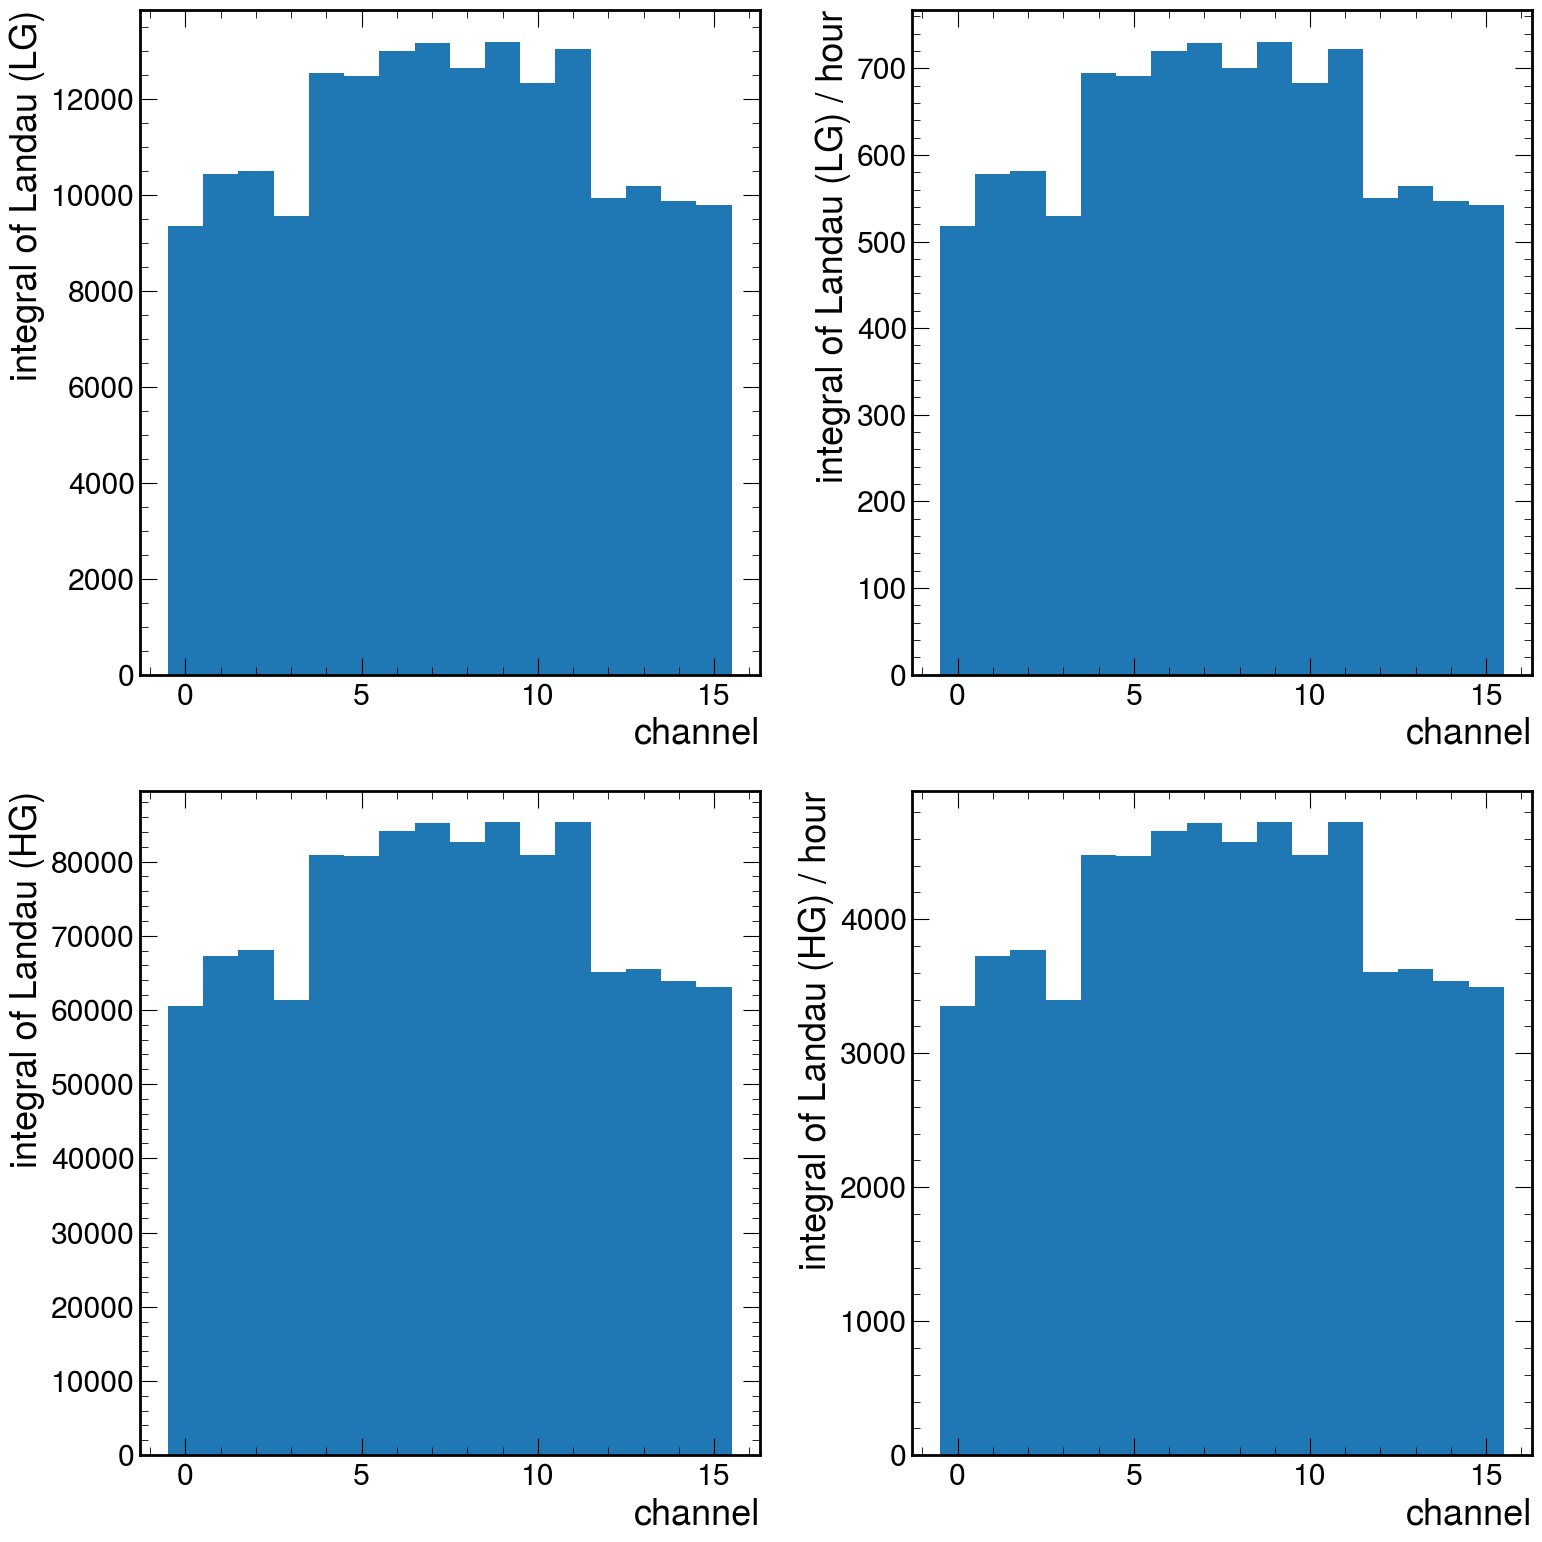

In [12]:
x=[]
y=[]
fig, axs=plt.subplots(2,2,figsize=(16,16))
for gain,row in zip(("LG", "HG"), axs):
    
    for ch in channels:
        x.append(int(ch))
        if (ch, gain) in integrals:
            y.append(integrals[(ch, gain)])
        else :
            y.append(0)
    plt.sca(row[0])
    plt.bar(x,y, 1)
    plt.xlabel("channel")
    plt.ylabel(f"integral of Landau ({gain})")
    plt.sca(row[1])
    dt=(df.timestamp[len(df)-1]-df.timestamp[0])/(3.6e9)
    plt.bar(x,np.array(y)/dt, 1)
    plt.xlabel("channel")
    plt.ylabel(f"integral of Landau ({gain}) / hour")
#plt.yscale('log')
plt.tight_layout()
plt.show()


/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


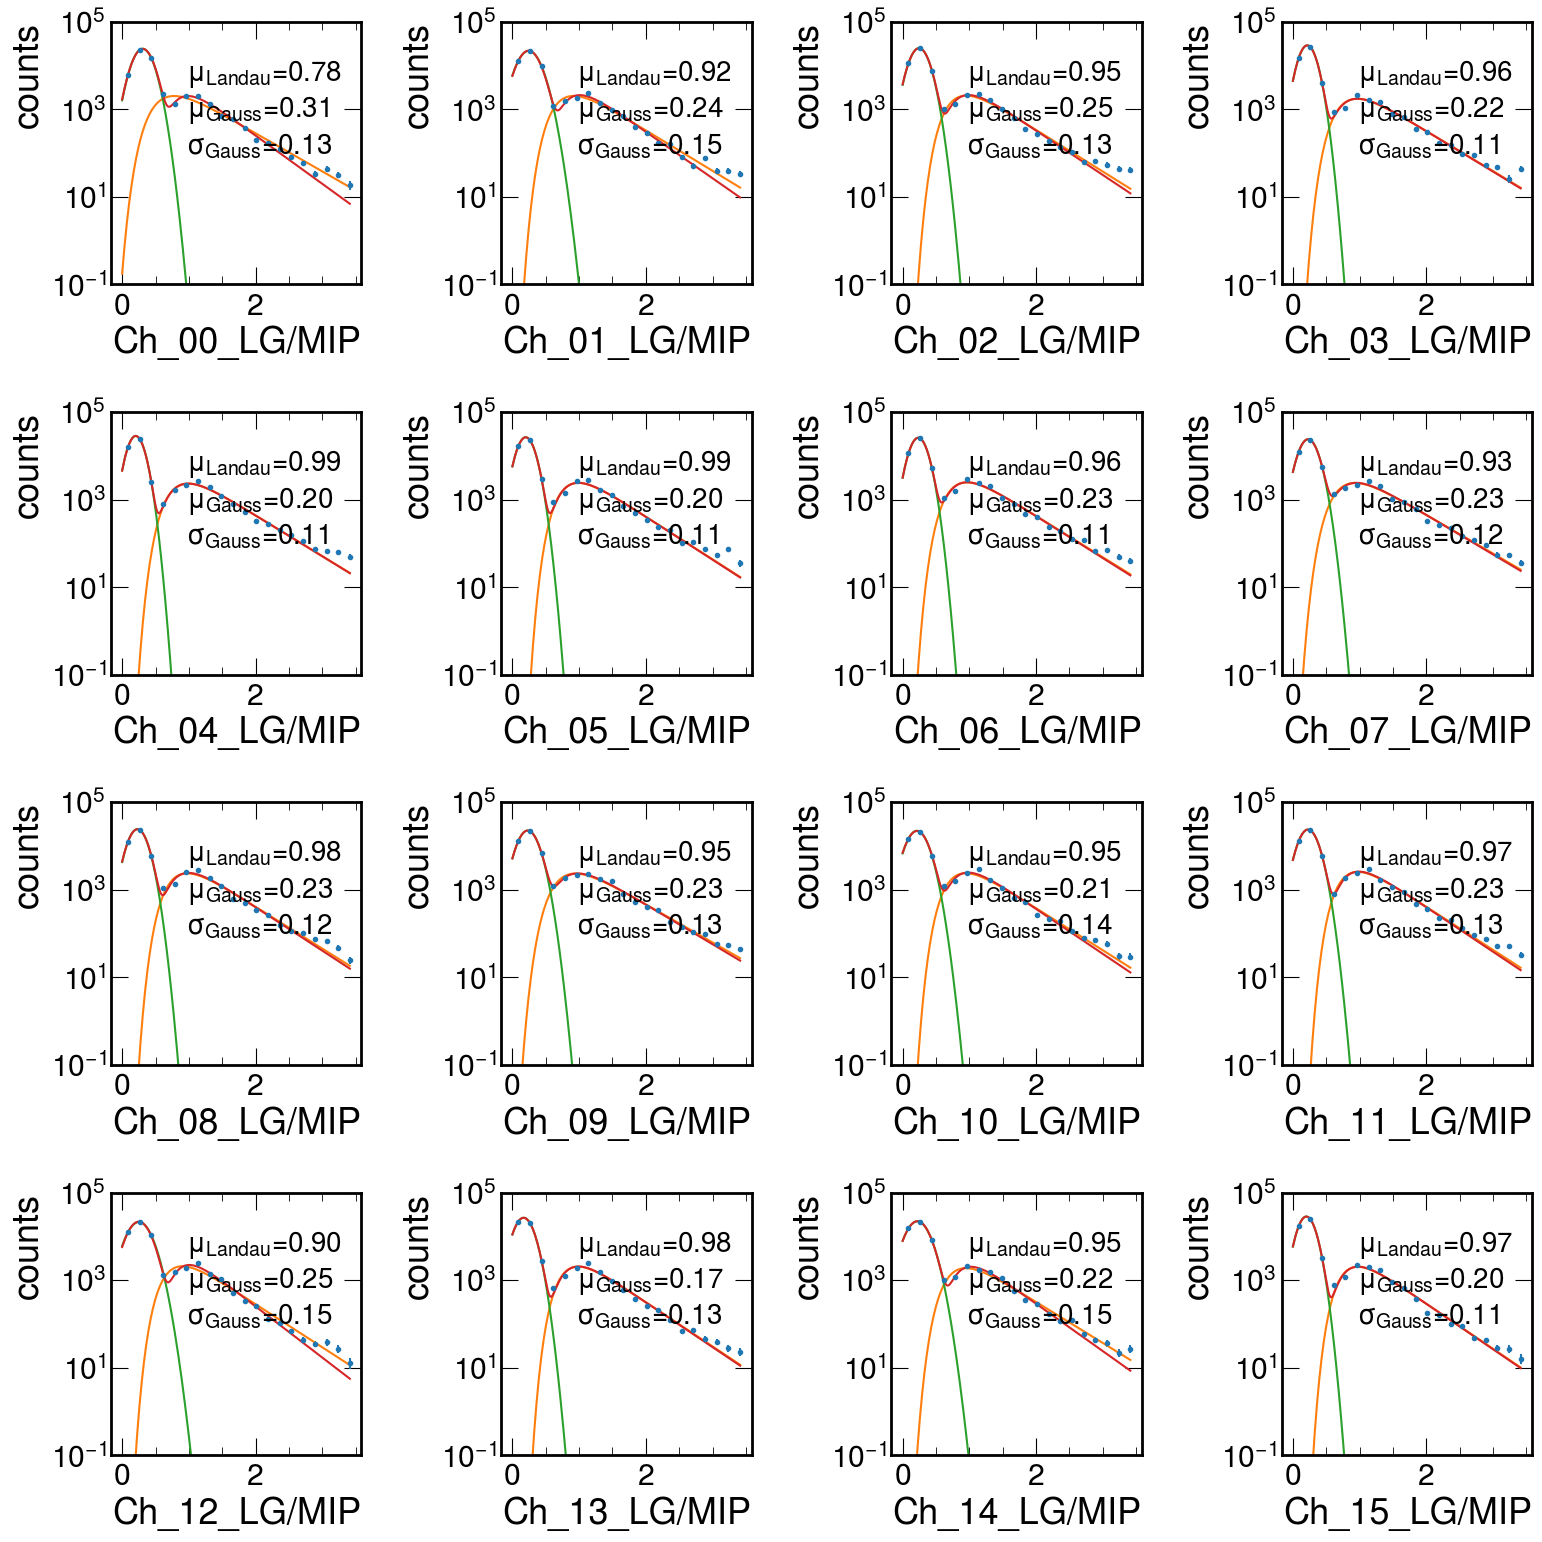

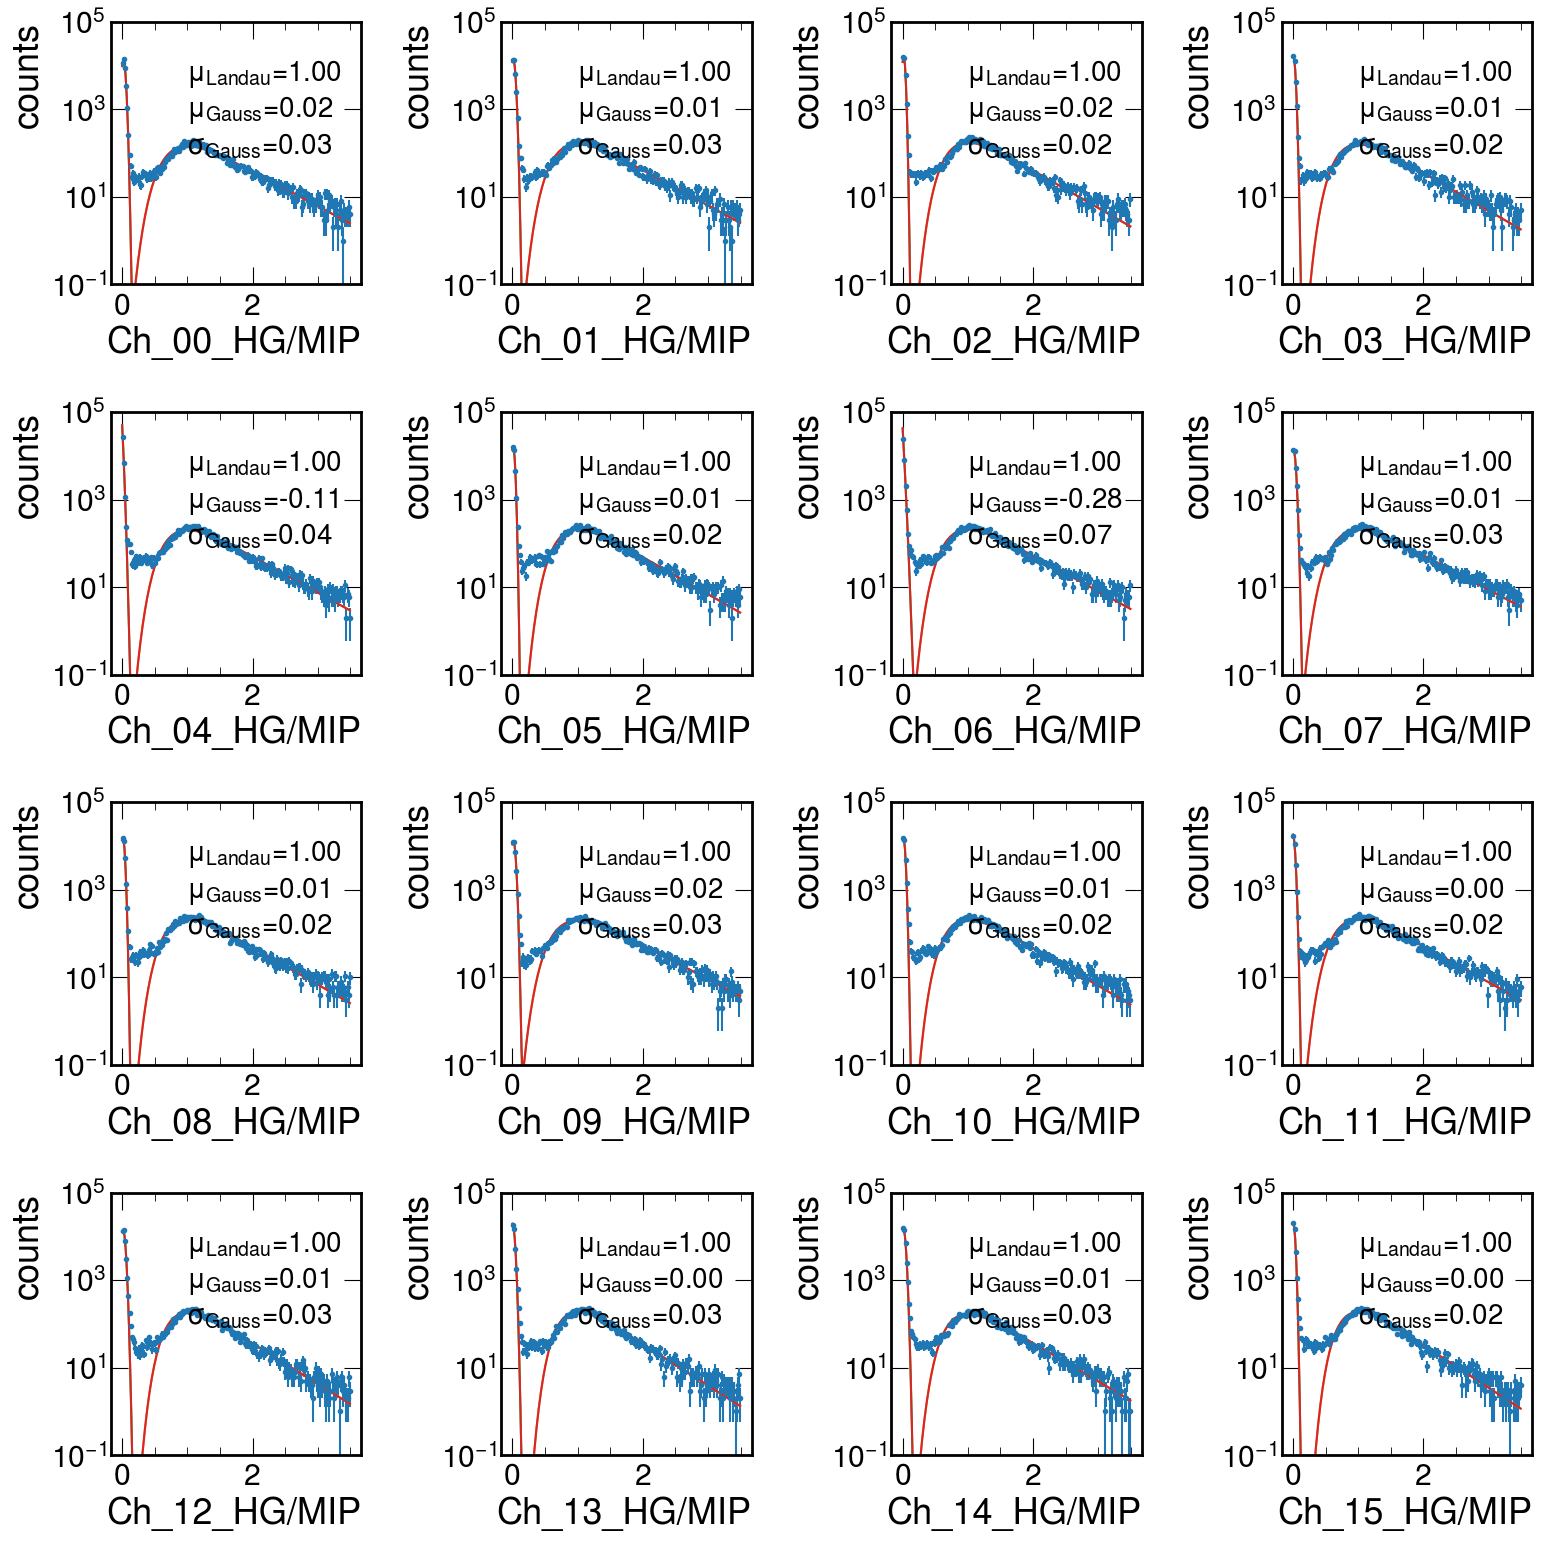

In [13]:
for gain in "LG HG".split():
    fig, axs=plt.subplots(nchannels//4,4, figsize=(16, 1*nchannels))
    for i in range(len(channels)):

            
        ch = channels[i]
        if (ch,gain) not in MIP:
            continue
        plt.sca(axs[i//4][i%4])
        plt.yscale("log")
        plt.ylim(0.1, 1e5)
        hist,x,= np.histogram(df.eval(f"Ch_{ch}_{gain}/{MIP[(ch,gain)]}"), bins=20 if gain== "LG" else 200, 
                              range=(0,3.5) if gain == "LG" else (0, 3.5))
        plt.xlabel(f"Ch_{ch}_{gain}/MIP")
        plt.ylabel("counts")

        bin_centers=(x[1:]+x[:-1])/2

        from scipy.optimize import curve_fit
        if gain=="LG":
            start,stop=int(.67/(x[1]-x[0])),None
        else :
            start,stop=int(0.1/(x[1]-x[0])),None
        p0=[1000, 1, 0.3]

        plt.errorbar(bin_centers, hist, np.sqrt(hist), linestyle='', marker='o', label='data', markersize=3)

        dhist=np.sqrt(hist)+(hist==0)
        try:
            coeff, var_matrix = curve_fit(Landau, bin_centers[start:stop], hist[start:stop], p0=p0,
                                 sigma=dhist[start:stop])

            from scipy.stats import chi2
            #chi2val = sum((Landau(bin_centers[start:stop], *coeff)-hist[start:stop])**2/dhist[start:stop]**2)
            #ndof = len(bin_centers[start:stop])-len(coeff)
            #print("chi2=",chi2val, "ndof=",ndof, "pval=", chi2.sf(chi2val, ndof))
            x=np.linspace(0, max(bin_centers), 200)
            mu=coeff[1]

            curve = plt.plot(x, Landau(x,*coeff), label=f"Landau")

            if gain=="LG":
                start, stop = 0, int(20/(bin_centers[1]-bin_centers[0])/30)
            else :
                start, stop = 0, int(400/(bin_centers[1]-bin_centers[0])/600)
            coeff_g, var_matrix = curve_fit(Gauss, bin_centers[start:stop], hist[start:stop], 
                                            p0=[10000,0.3,0.05] if gain=='LG' else [10000, 0.01, 0.05],
                                     sigma=dhist[start:stop])

            curve = plt.plot(x, Gauss(x,*coeff_g), label=f"Gauss")

            coeff_lg, var_matrix = curve_fit(LandauPlusGauss, bin_centers, hist, p0=list(coeff)+list(coeff_g),
                                     sigma=dhist)

            curve = plt.plot(x, LandauPlusGauss(x,*coeff_lg), label=f"Landau+Gauss")

            #plt.legend(fontsize=12)
            mu=coeff_lg[1]
            mu_g=coeff_lg[4]
            sigma_g=abs(coeff_lg[5])

            mu=coeff[1]
            plt.text(0.30, 0.5, f"$\mu_{{\\rm Landau}}$={mu:.2f}\n$\mu_{{\\rm Gauss}}$={mu_g:.2f}\n$\\sigma_{{\\rm Gauss}}$={sigma_g:.2f}", transform=plt.gca().transAxes, fontsize=20)
            
        except RuntimeError:
            pass
    plt.tight_layout()

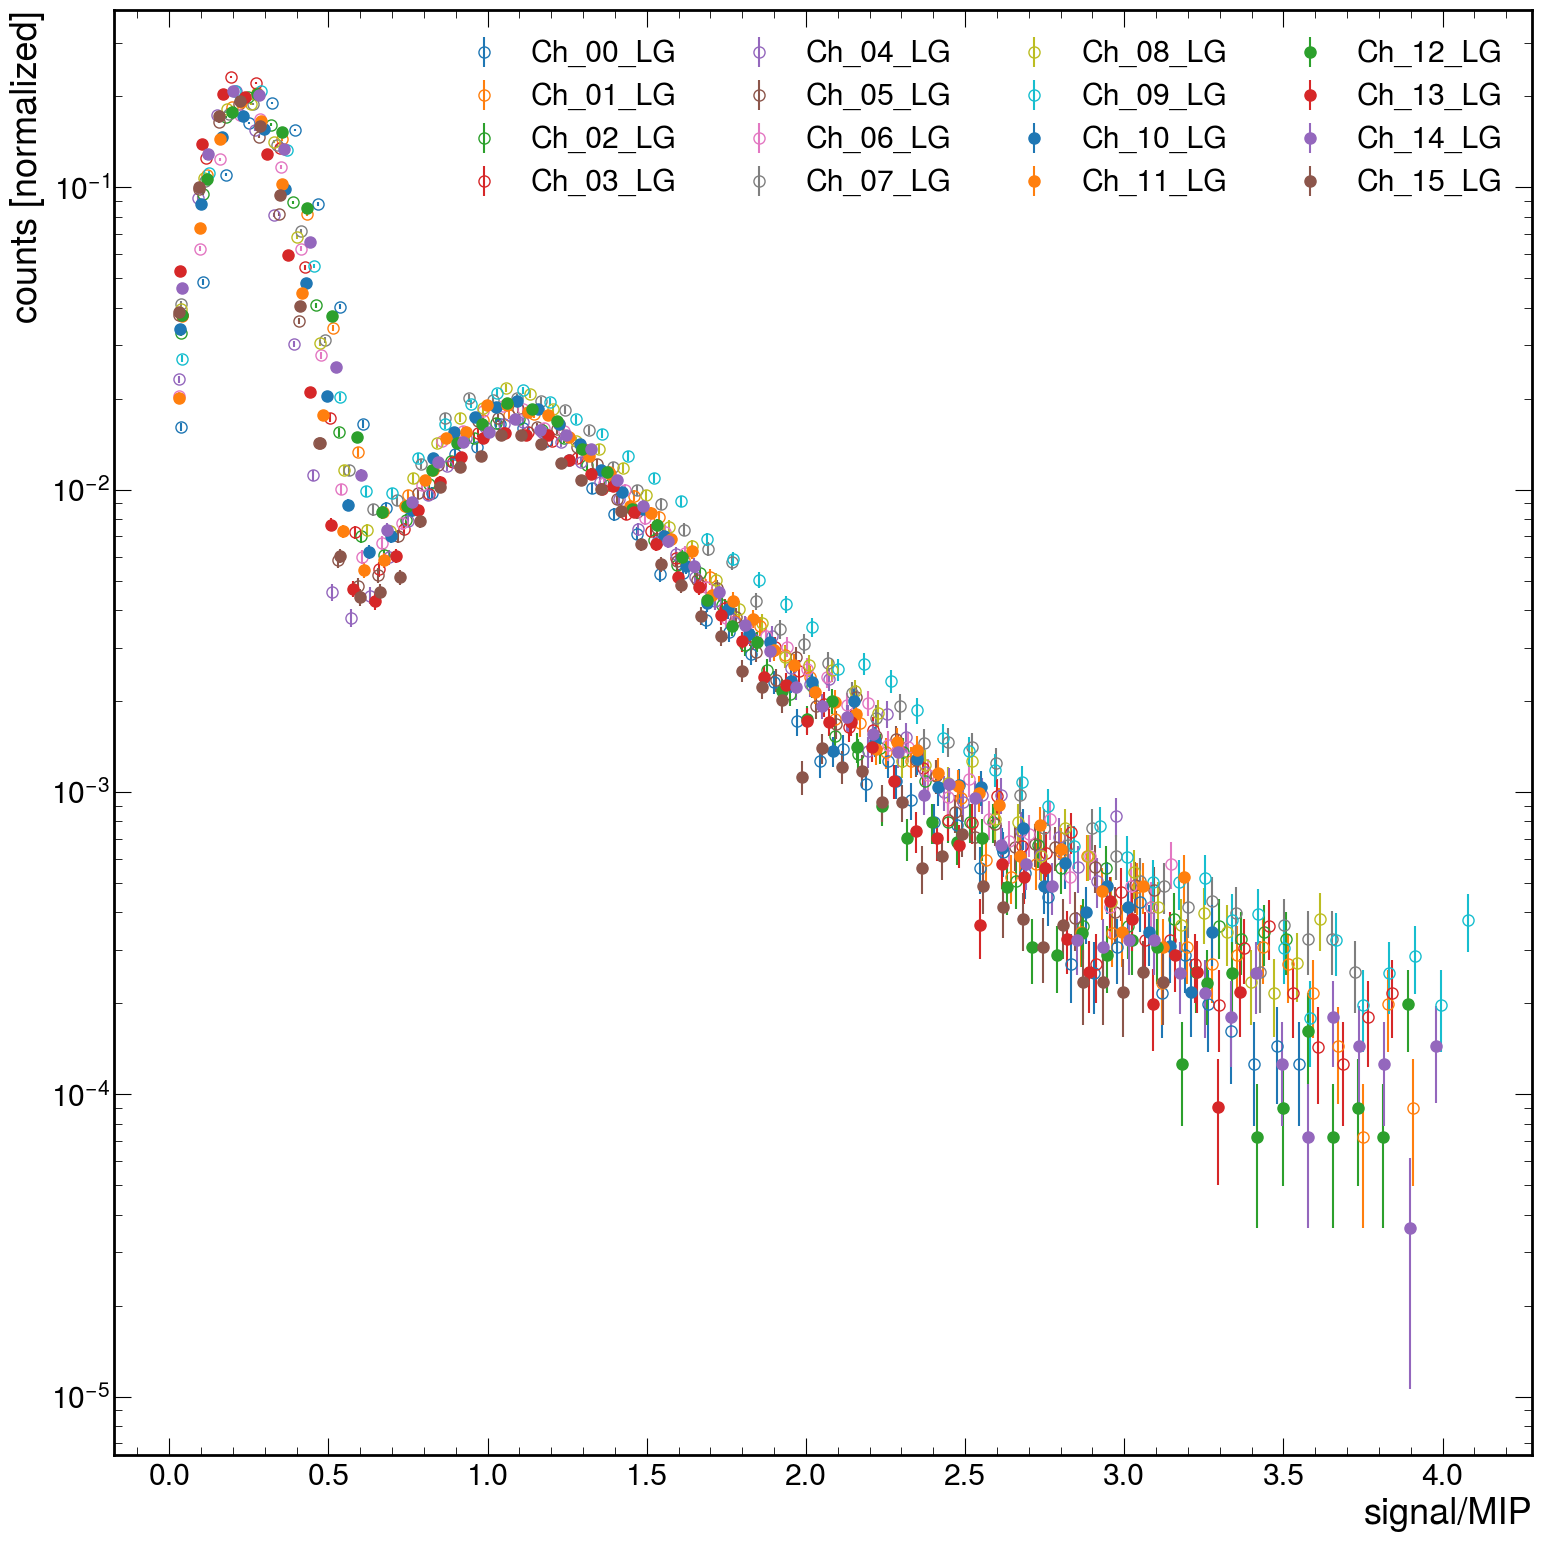

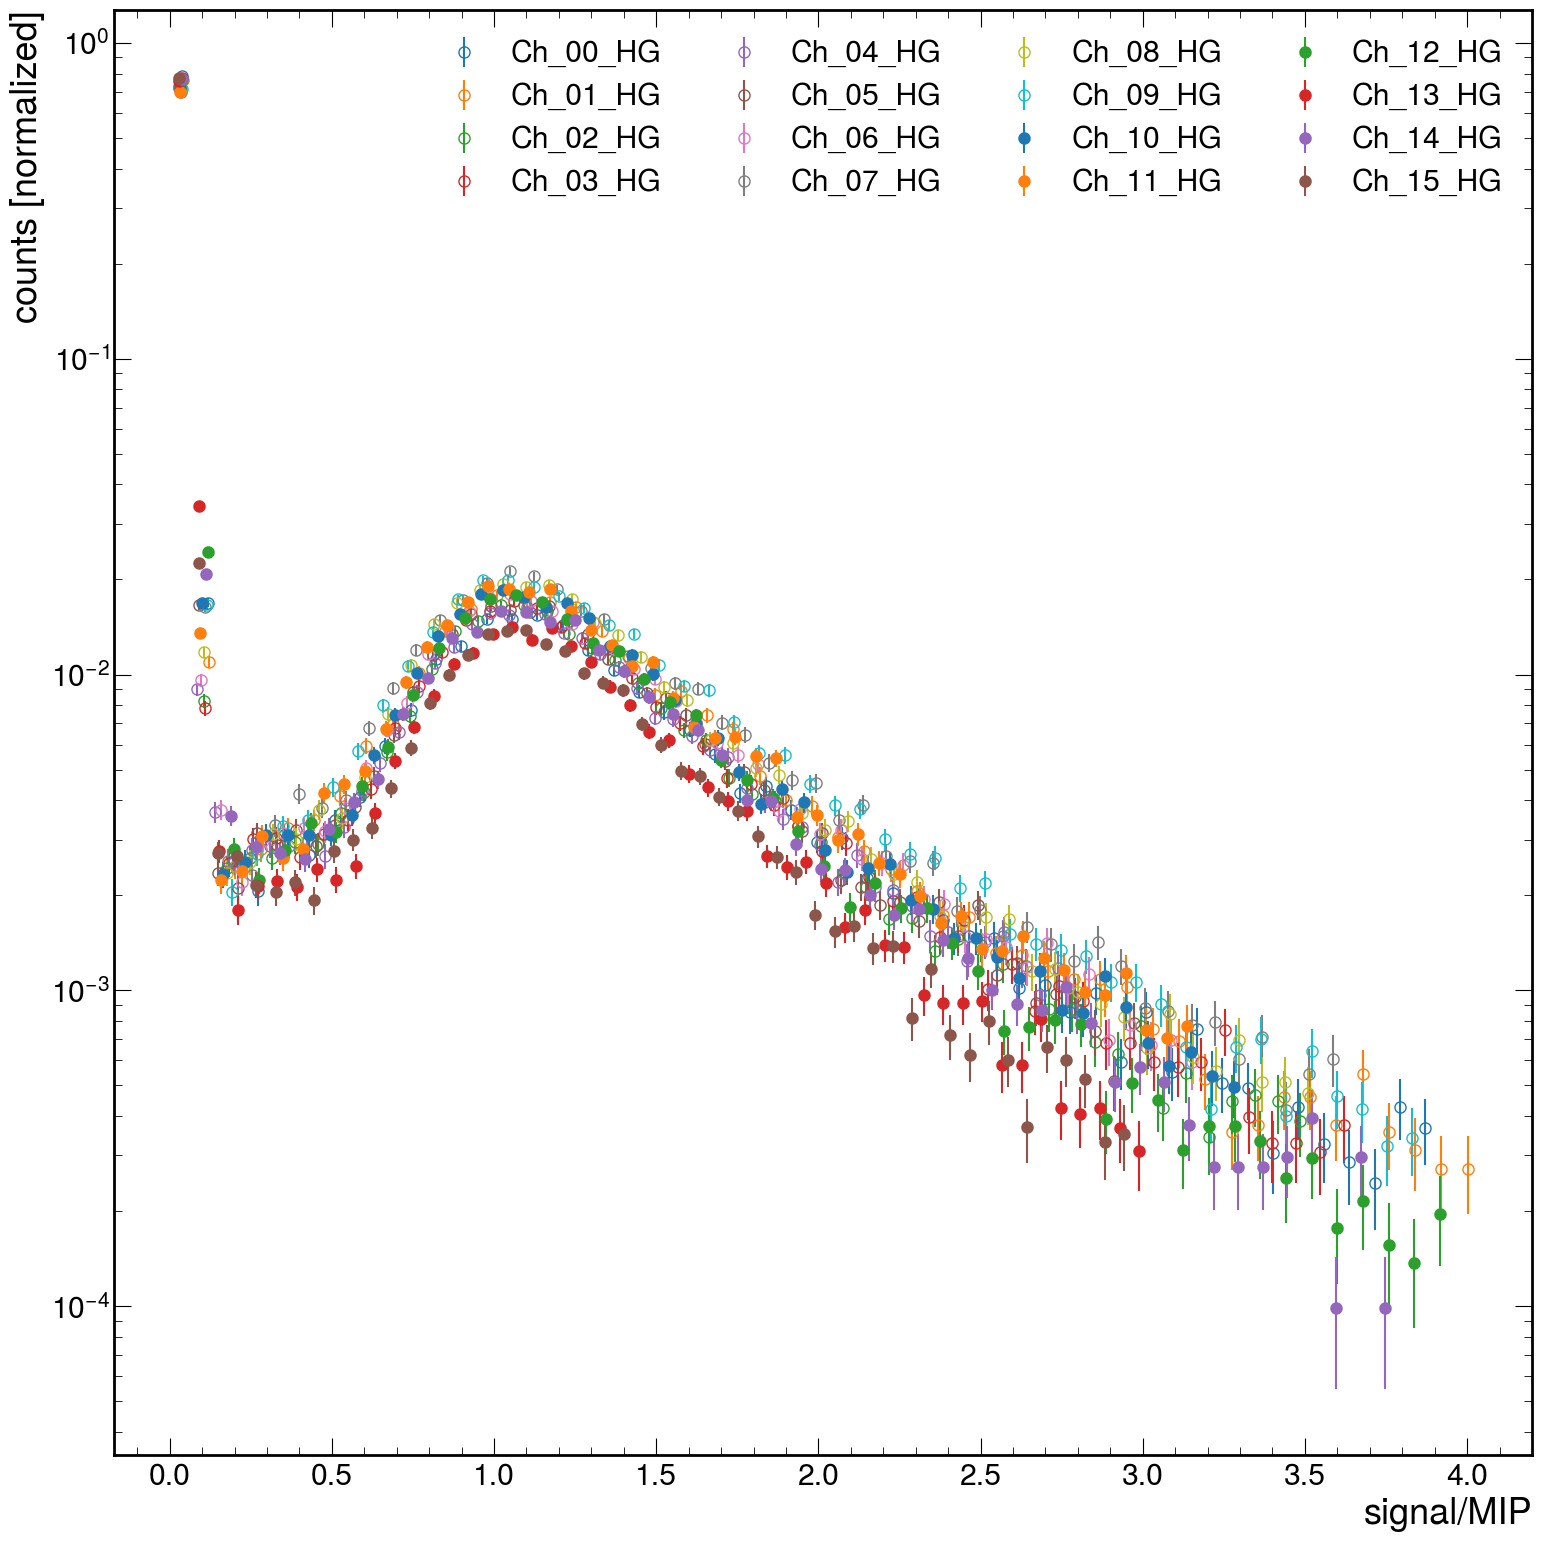

In [16]:
#must run previous cell to get the MIP values before this one
for gain in "LG HG".split():
    fig, axs=plt.subplots(1,1, figsize=(16, 16))
    for i in range(len(channels)):
        
        ch = channels[i]
        
        
        
        hist,x,= np.histogram(df.eval(f"Ch_{ch}_{gain}"), bins=50, 
                              range=(0,LG_hist_max) if gain == "LG" else (0, HG_hist_max))
        xlabel=f"signal/MIP"

        plt.xlabel(xlabel)
        plt.ylabel("counts [normalized]")

        bin_centers=(x[1:]+x[:-1])/2


        plt.yscale("log")
            #plt.ylim(0.001, 1e3)
        dhist=np.sqrt(hist)+(hist==0)

        if (ch, gain) not in MIP:
            continue
        scale=1/MIP[(ch, gain)]
        yscale=1/sum(hist[start:stop])
        plt.errorbar(bin_centers*scale, hist*yscale, np.sqrt(hist)*yscale, 
                     linestyle='', marker='o' if i<20 else 's' if i<40 else 'v' if i<60 else '^' , markersize=8, fillstyle='none' if (i%20) < 10 \
                    else 'full' , label=f'Ch_{ch}_{gain}')
    
    plt.legend(ncol=4)
    plt.tight_layout()
    plt.show()

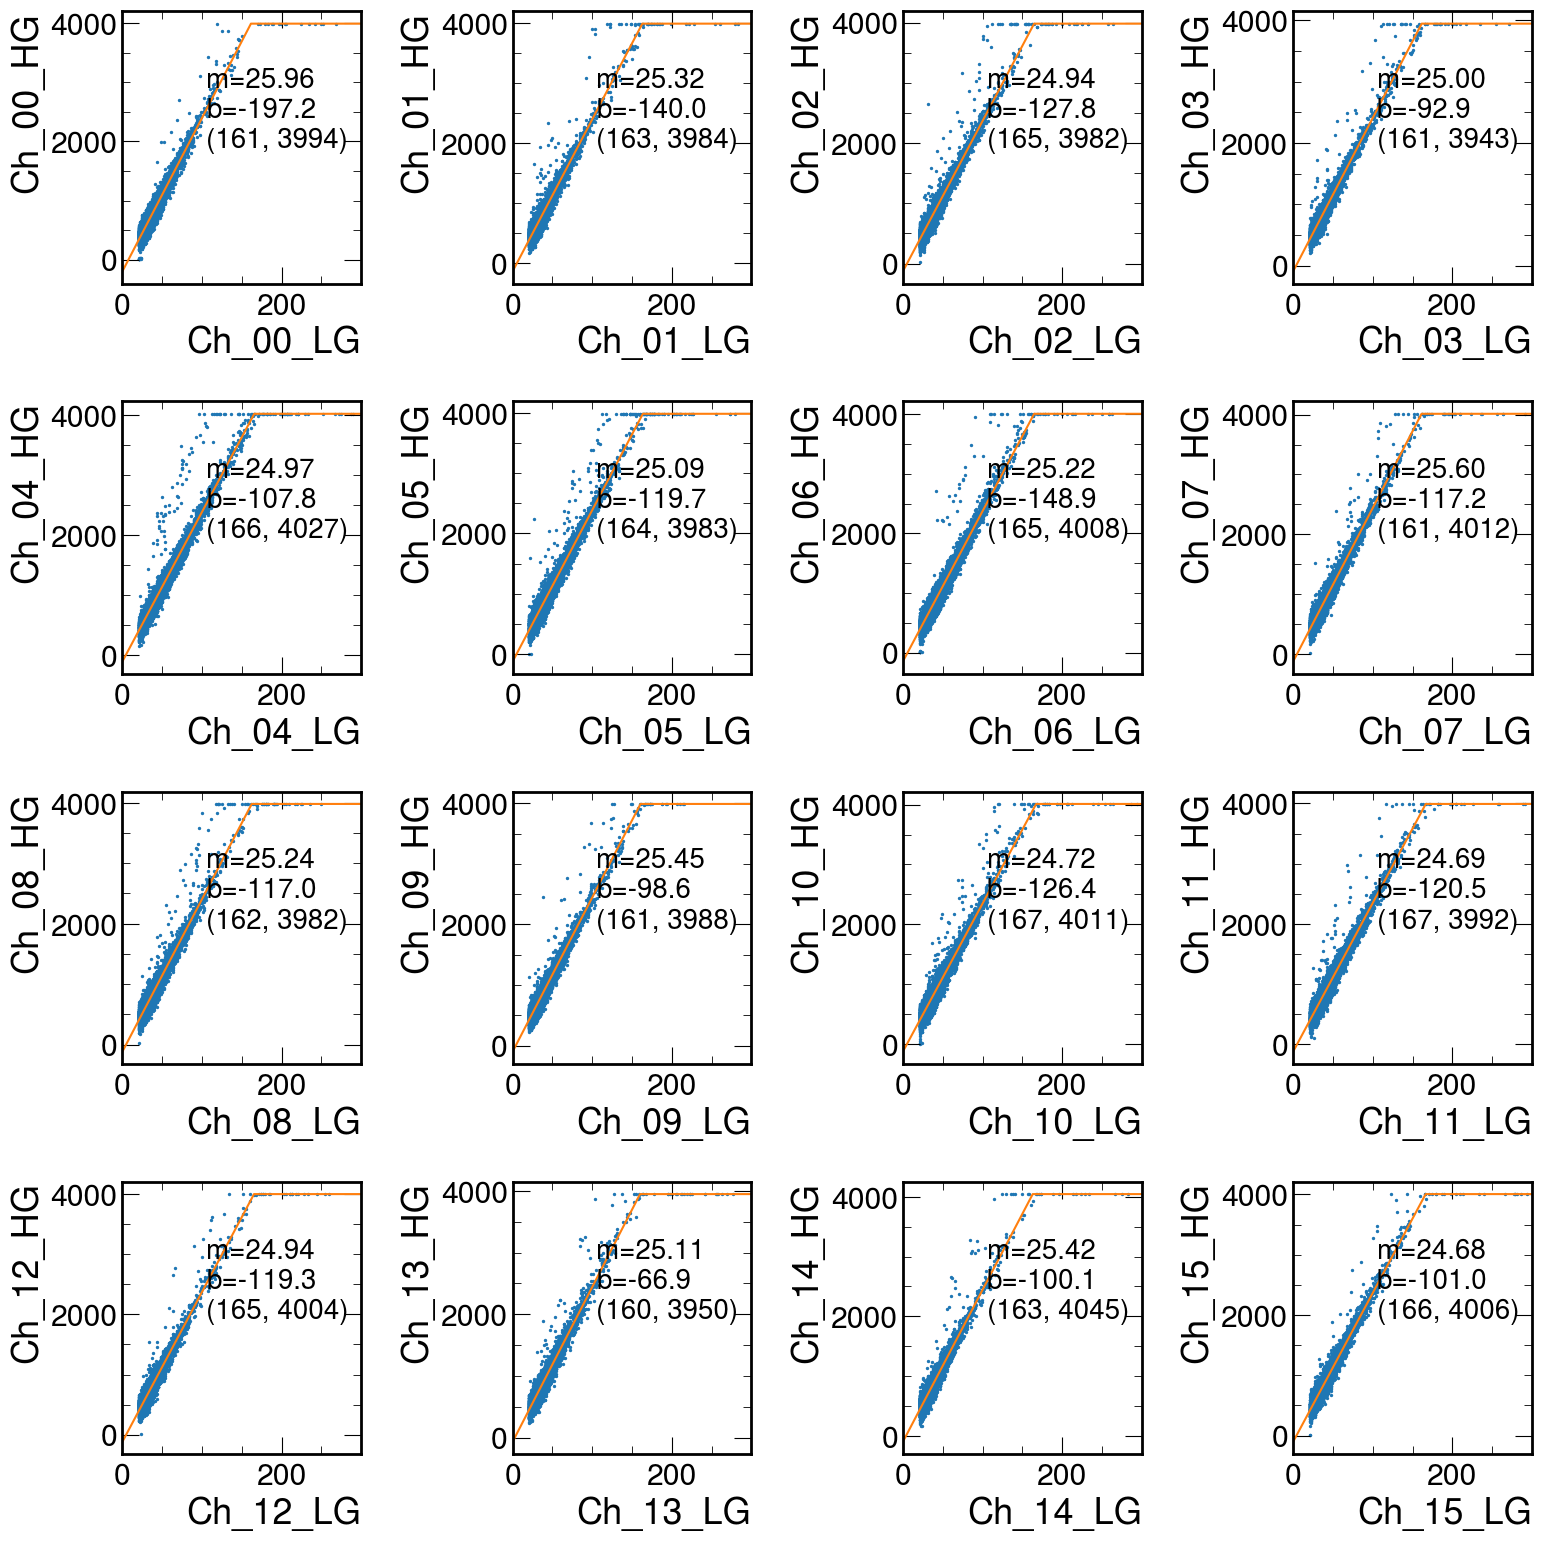

In [17]:
fig, axs=plt.subplots(nchannels//4,4, figsize=(16, 1.0*nchannels))

for i in range(len(channels)):
    ch = channels[i]
    plt.sca(axs[i//4][i%4])
    
    q= f"Ch_{ch}_LG>{LG_cut} and Ch_{ch}_HG<5000 and Ch_{ch}_LG<1000"
    plt.scatter(df.query(q).eval(f"Ch_{ch}_LG"), df.query(q).eval(f"Ch_{ch}_HG"),s=2)
    plt.xlabel(f"Ch_{ch}_LG")
    plt.ylabel(f"Ch_{ch}_HG")
    
    q=f"Ch_{ch}_LG>{LG_cut} and Ch_{ch}_HG>{HG_cut} and Ch_{ch}_HG<5000 and Ch_{ch}_LG<1000"
    x= df.query(q).eval(f"Ch_{ch}_LG") 
    y = df.query(q).eval(f"Ch_{ch}_HG")
    #print(max(y), np.mean(df.query(f"Ch_{ch}_HG>{0.95*max(y)}").eval(f"Ch_{ch}_HG"))/max(y))
    if len(y)==0:
        print("warning ch ", ch, "is empty")
        continue
    q= f"Ch_{ch}_HG<{max(y)} and Ch_{ch}_LG>{LG_cut} and Ch_{ch}_HG>{HG_cut} and Ch_{ch}_HG<5000 and Ch_{ch}_LG<1000"
    xf= df.query(q).eval(f"Ch_{ch}_LG")
    yf= df.query(q).eval(f"Ch_{ch}_HG")
    m=(np.sum(xf*yf)*len(xf)-np.sum(xf)*np.sum(yf))/(np.sum(xf*xf)*len(xf)-np.sum(xf)*np.sum(xf))
    b = (sum(yf)-m*sum(xf))/len(xf)
    xelbow=(max(y)-b)/m
    yelbow=max(y)
    plt.plot([0, xelbow, max(df.eval(f"Ch_{ch}_LG"))], [b, yelbow, yelbow], linestyle='-', color='tab:orange')
    plt.text(0.35, 0.5, f"m={m:.2f}\nb={b:.1f}\n({xelbow:.0f}, {yelbow:.0f})", transform=plt.gca().transAxes, fontsize=20)
    plt.xlim(0, 300)
plt.tight_layout()

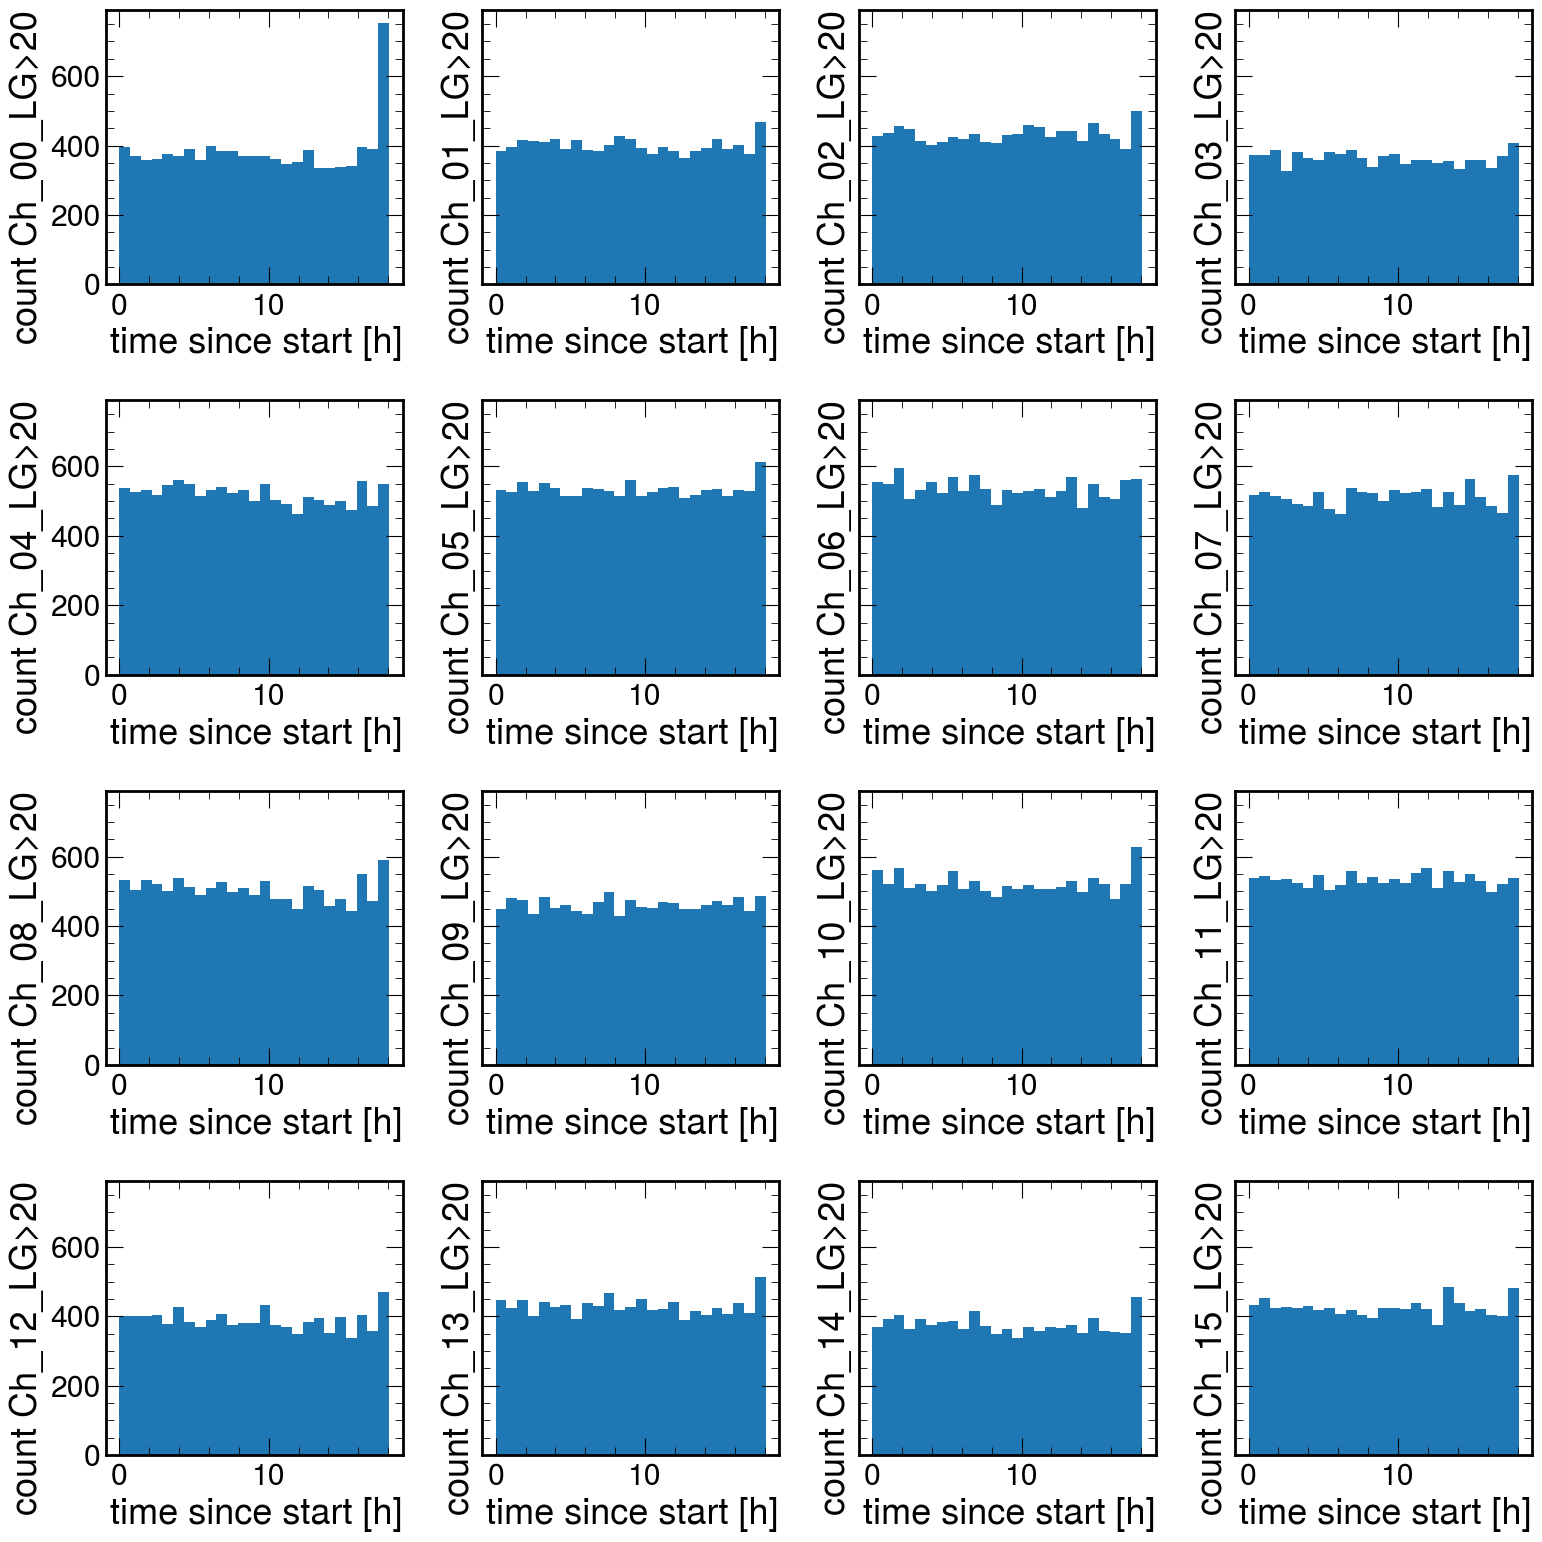

In [19]:
fig, axs=plt.subplots(nchannels//4,4, figsize=(16, 1.0*nchannels),sharey='all')

for i in range(len(channels)):
    ch = channels[i]
    plt.sca(axs[i//4][i%4])
    plt.hist(df.query(f"Ch_{ch}_LG>{LG_cut}").eval(f"timestamp/3.6e9"), bins=25, range=(0,max(df.timestamp)/3.6e9))
    plt.xlabel(f"time since start [h]")
    plt.ylabel(f"count Ch_{ch}_LG>{LG_cut}")
plt.tight_layout()

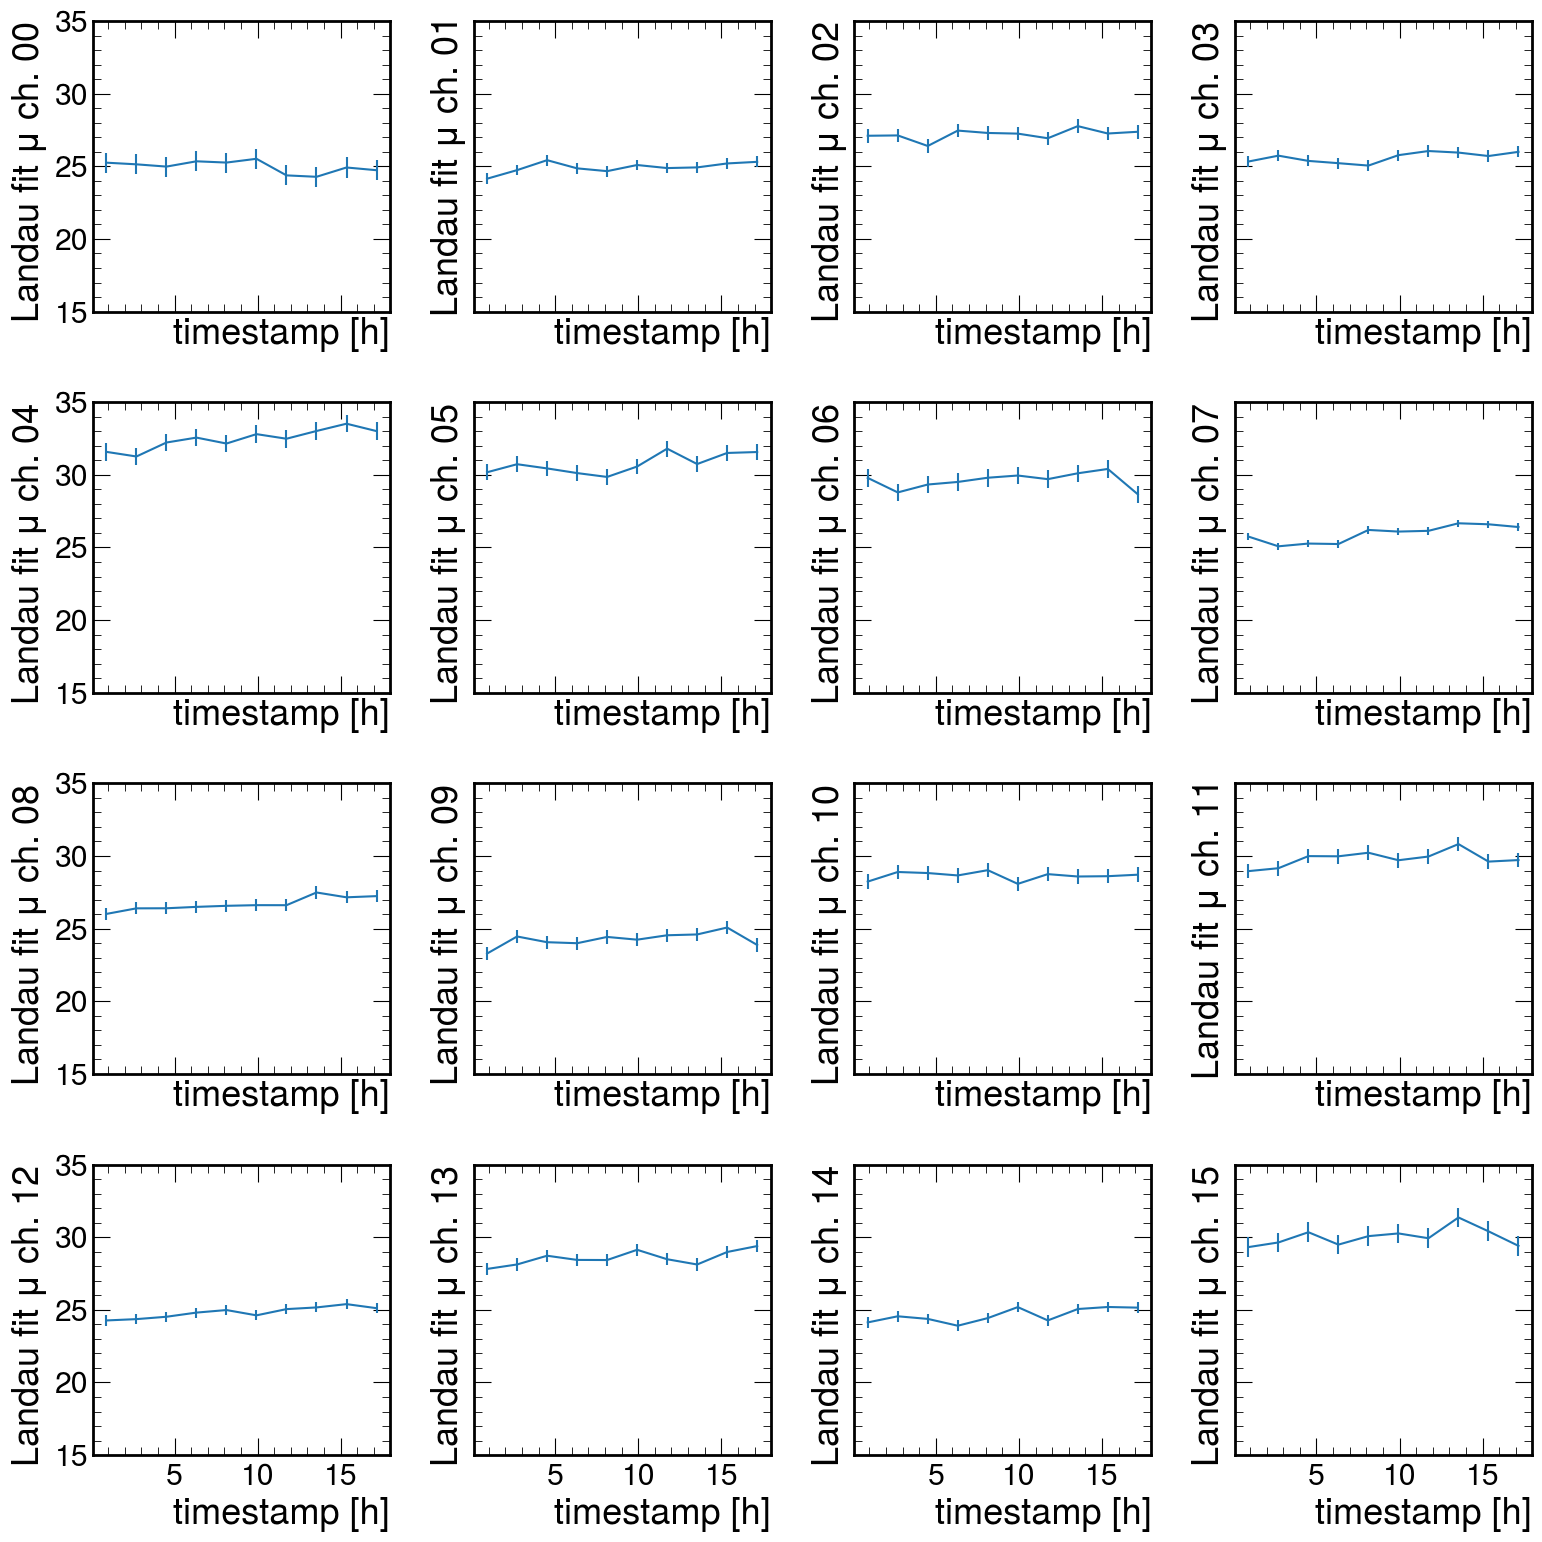

In [20]:
fig, axs=plt.subplots(nchannels//4,4, figsize=(16, 1.0*nchannels),sharex='all', sharey='all')

for i in range(len(channels)):
    ch = channels[i]
    plt.sca(axs[i//4][i%4])
    slices = np.linspace(min(df.timestamp), max(df.timestamp), 11)
    mus=[]
    dmus=[]
    centers=[]
    for j in range(len(slices)-1):
        try:
            hist,x,= np.histogram(df.query(f"timestamp>{slices[j]} and timestamp<{slices[j+1]}")\
                                  .eval(f"Ch_{ch}_LG"), bins=26, range=(0,200))


            bin_centers=(x[1:]+x[:-1])/2

            from scipy.optimize import curve_fit
            start,stop=int(LG_cut/(x[1]-x[0])),None
            p0=[1000, 30, 10]

            #plt.errorbar(bin_centers, hist, np.sqrt(hist), linestyle='', marker='o', label='data')

            dhist=np.sqrt(hist[start:stop])+(hist[start:stop]==0)
            #print(i,j)
            coeff, var_matrix = curve_fit(Landau, bin_centers[start:stop], hist[start:stop], p0=p0,
                                     sigma=dhist)
            from scipy.stats import chi2
            chi2val = sum((Landau(bin_centers[start:stop], *coeff)-hist[start:stop])**2/dhist**2)
            ndof = len(bin_centers[start:stop])-len(coeff)
            #print("chi2=",chi2val, "ndof=",ndof, "pval=", chi2.sf(chi2val, ndof))
            x=np.linspace(0, 140, 280)
            mu=coeff[1]
            
            dmu=np.sqrt(var_matrix[1][1])
            if abs(mu)>1000 or abs(dmu)>1000 or var_matrix[1][1]<0 :
                continue
            mus.append(mu)
            dmus.append(dmu)
            centers.append((slices[j]+slices[j+1])/2)
        except RuntimeError:
            pass
    plt.ylim(15, 35)
    plt.errorbar(np.array(centers)/(3.6e9), mus, dmu)
    plt.xlabel(f"timestamp [h]")
    plt.ylabel(f"Landau fit $\mu$ ch. {ch}")
    
plt.tight_layout()

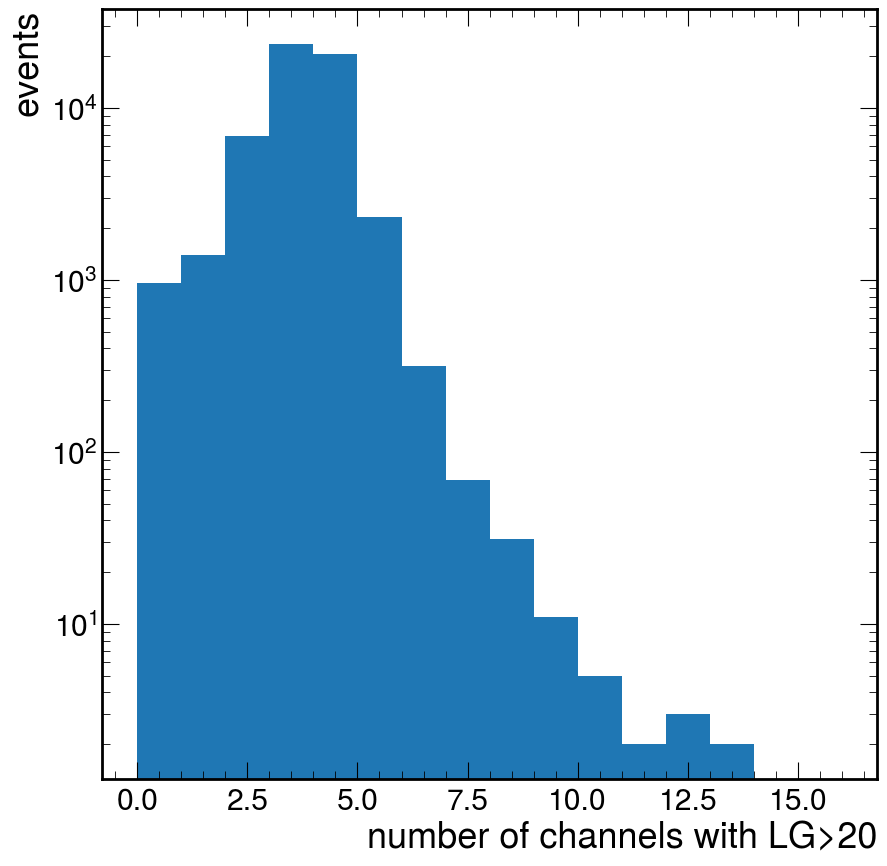

In [21]:
a="0"
for ch in channels:
    a+=f"+1*(Ch_{ch}_LG>{LG_cut})"
plt.hist(df.eval(a),bins=nchannels, range=(0,nchannels))
plt.xlabel(f"number of channels with LG>{LG_cut}")
plt.ylabel("events")
plt.yscale('log')
plt.show()

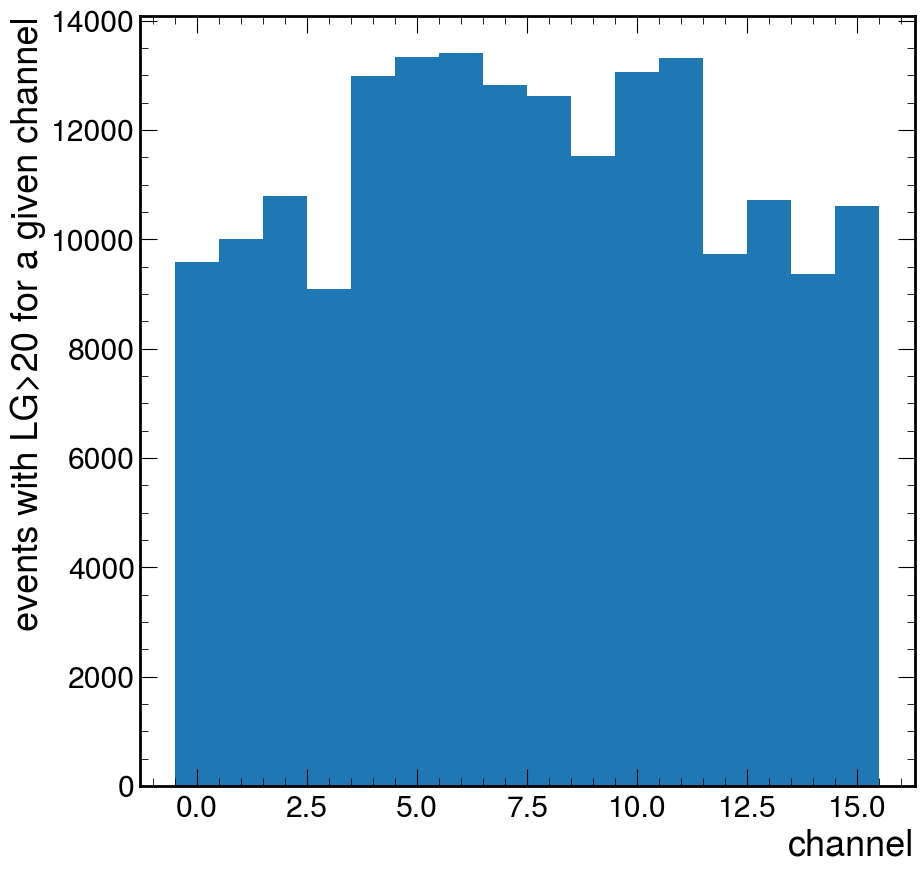

In [23]:
x=[]
y=[]
for ch in channels:
    x.append(int(ch))
    y.append(len(df.query(f"Ch_{ch}_LG>{LG_cut}")))
plt.bar(x,y, 1)
plt.xlabel("channel")
plt.ylabel(f"events with LG>{LG_cut} for a given channel")
#plt.yscale('log')
plt.show()

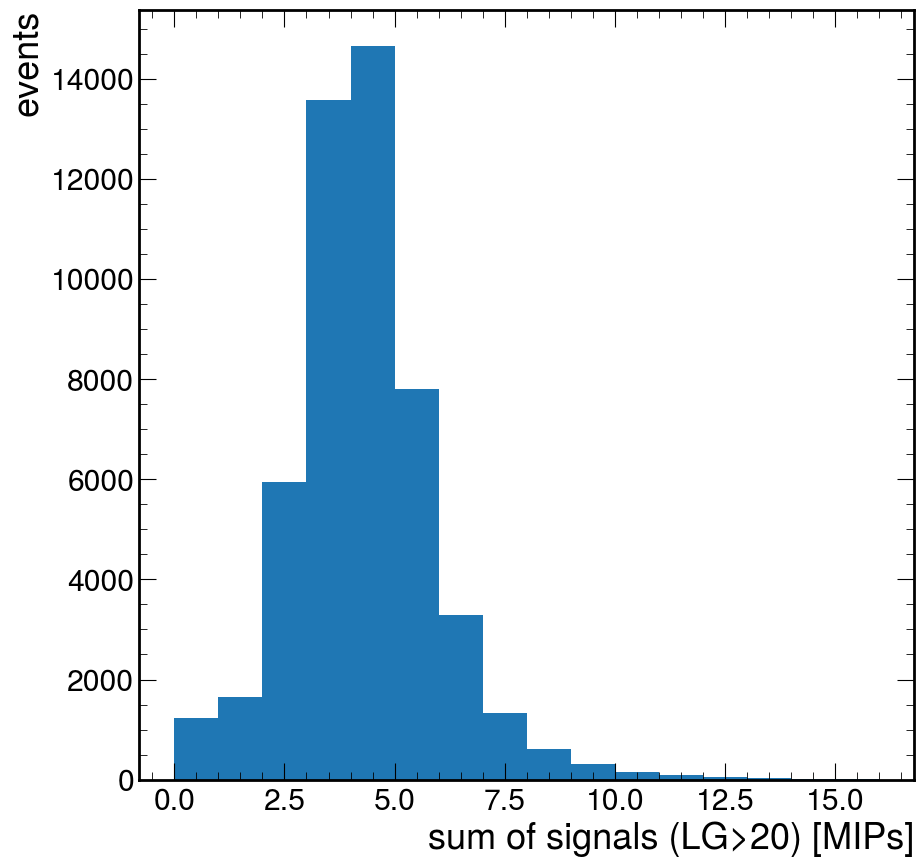

In [24]:
a="0"
for ch in channels:
    if (ch,'LG') in MIP:
        a+=f"+Ch_{ch}_LG*(Ch_{ch}_LG>{LG_cut})/{MIP[(ch,'LG')]}"
plt.hist(df.eval(a),bins=nchannels, range=(0,nchannels))
plt.xlabel(f"sum of signals (LG>{LG_cut}) [MIPs]")
plt.ylabel("events")
#plt.yscale('log')
plt.show()

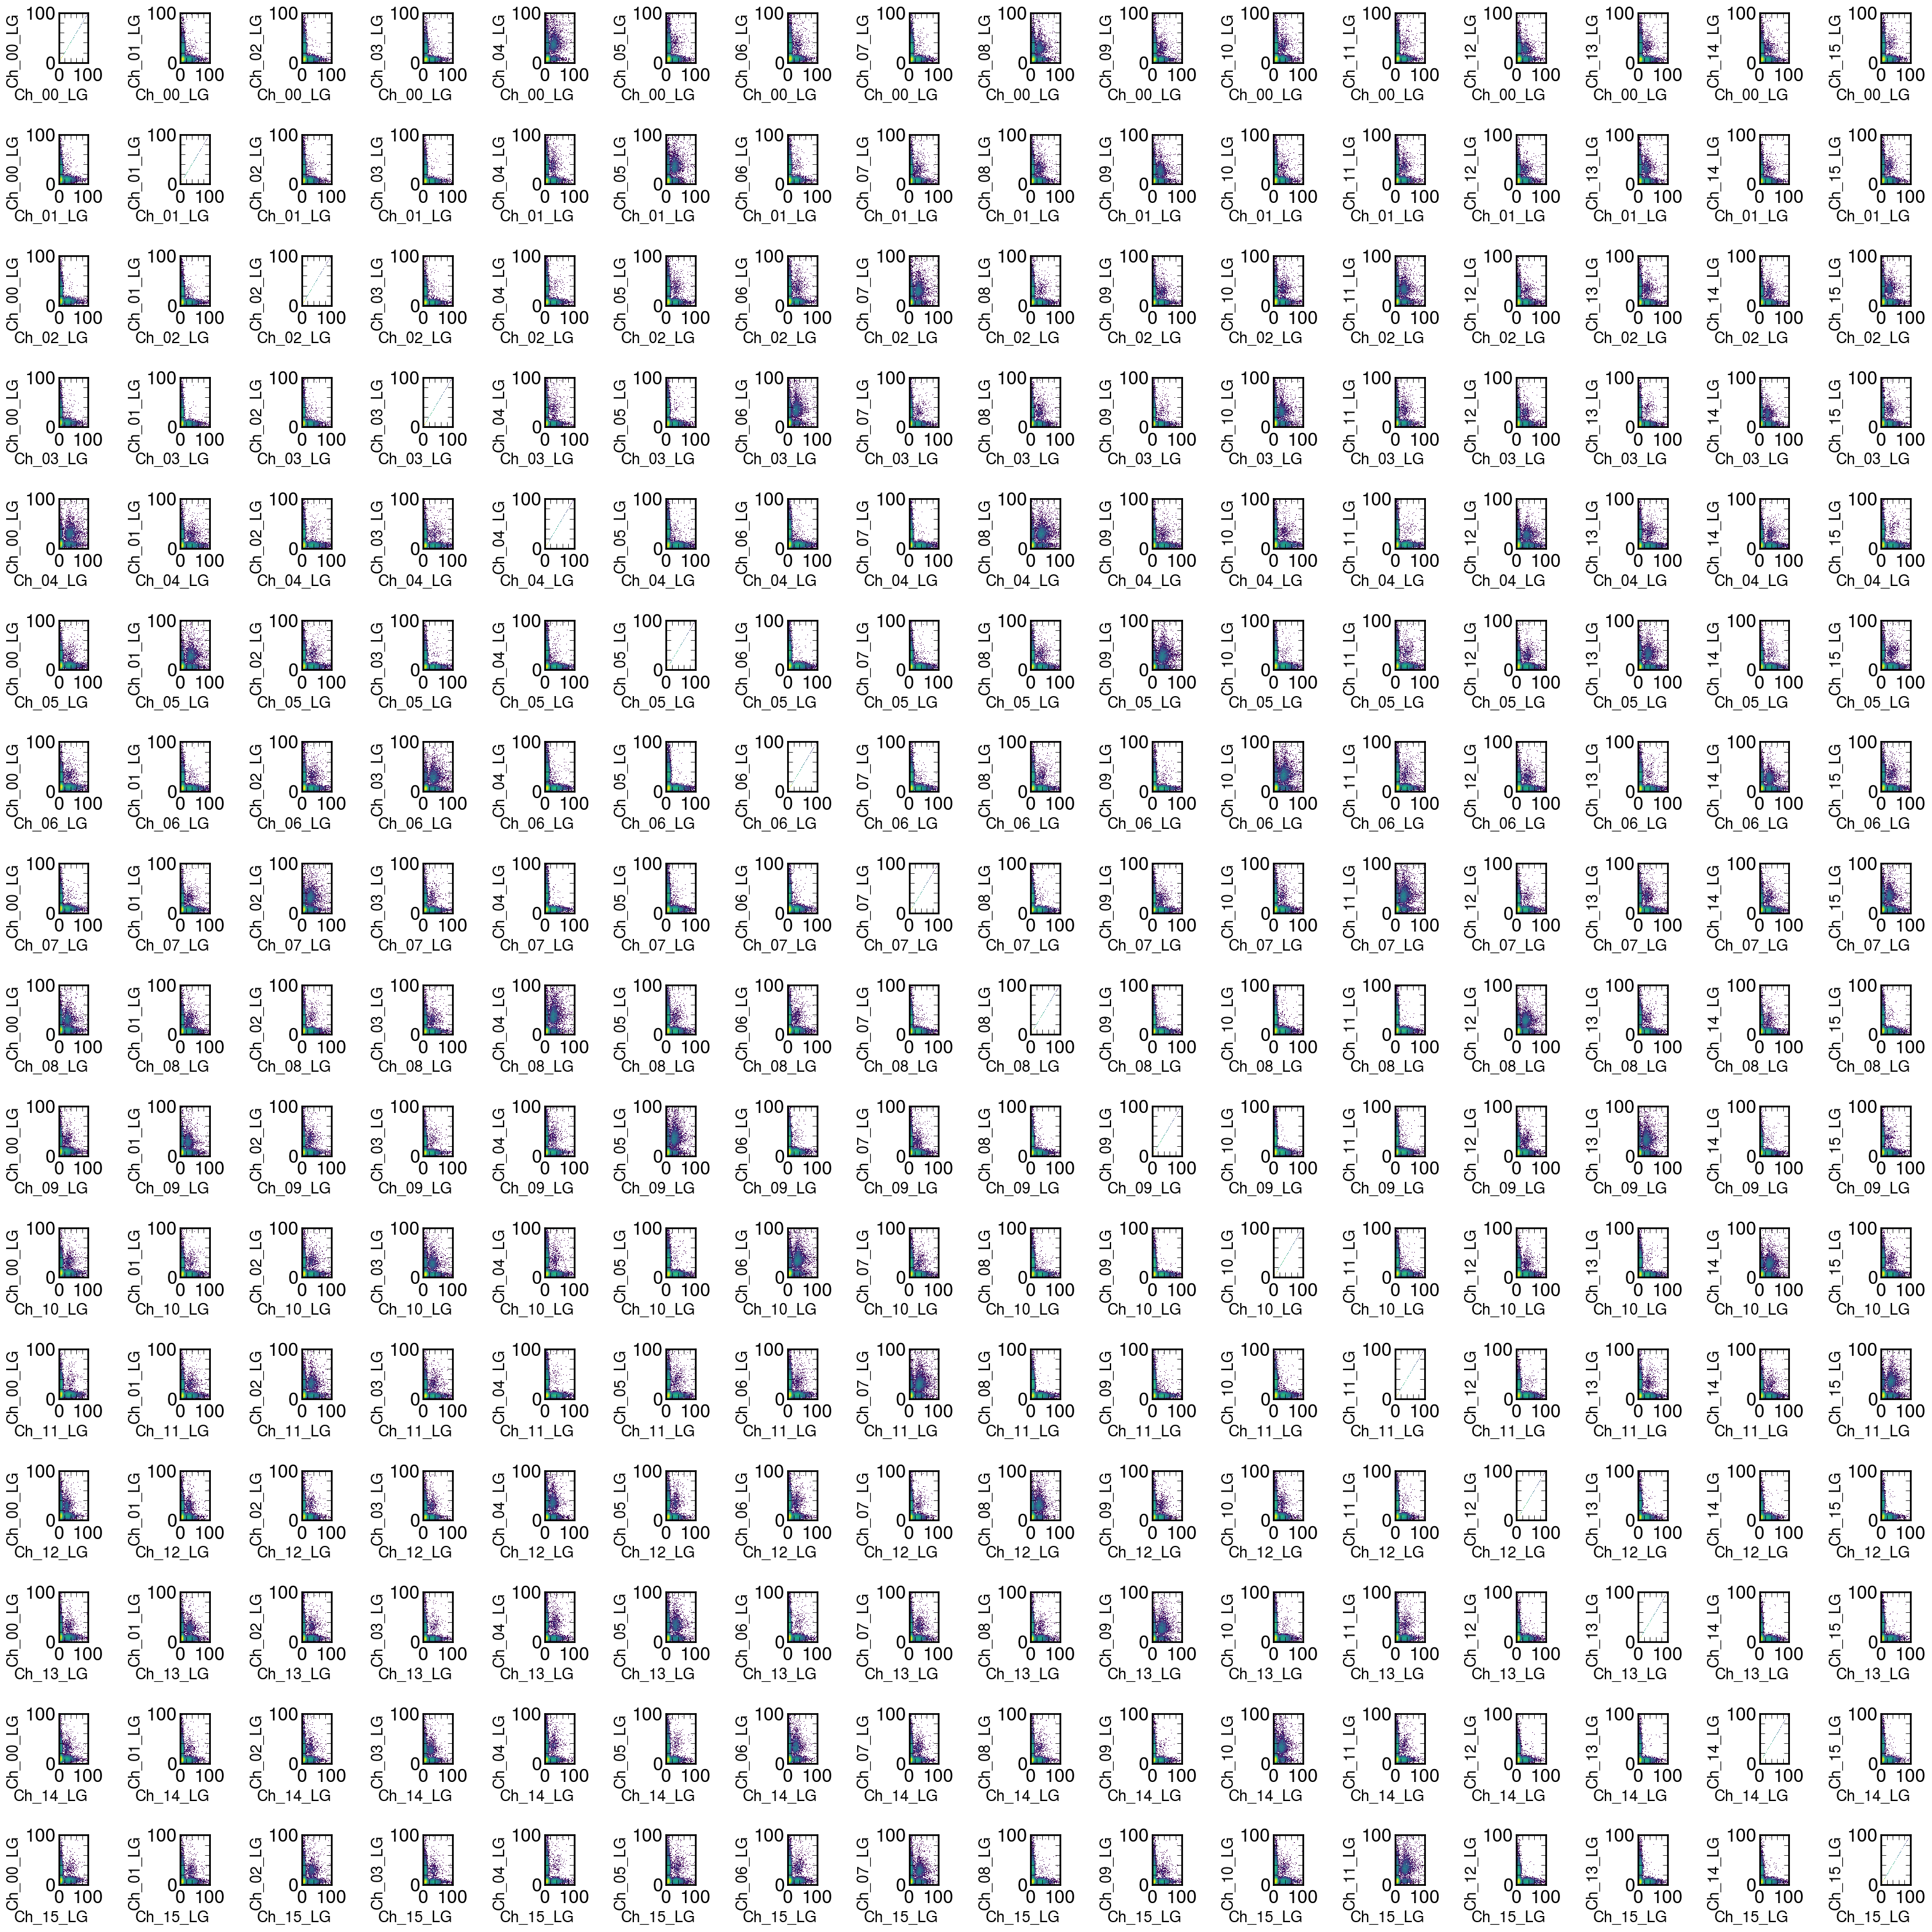

In [26]:
import matplotlib as mpl
fig, axs=plt.subplots(nchannels,nchannels, figsize=(2*nchannels,2*nchannels))
for ch1 in channels:
    for ch2 in channels:
        plt.sca(axs[int(ch1)][int(ch2)])
        plt.hist2d(df[f"Ch_{ch1}_LG"],df[f"Ch_{ch2}_LG"], bins=100, range=((0, LG_hist_max), (0, LG_hist_max)),
                  norm = mpl.colors.LogNorm())
        plt.xlabel(f"Ch_{ch1}_LG", fontsize=18)
        plt.ylabel(f"Ch_{ch2}_LG", fontsize=18)
plt.tight_layout()

00:   (Ch_04_LG>20)
01:   (Ch_05_LG>20)
02:   (Ch_07_LG>20)
03:   (Ch_06_LG>20)
04:   (Ch_00_LG>20) and (Ch_08_LG>20)
05:   (Ch_01_LG>20) and (Ch_09_LG>20)
06:   (Ch_03_LG>20) and (Ch_10_LG>20)
07:   (Ch_02_LG>20) and (Ch_11_LG>20)
08:   (Ch_04_LG>20) and (Ch_12_LG>20)
09:   (Ch_05_LG>20) and (Ch_13_LG>20)
10:   (Ch_06_LG>20) and (Ch_14_LG>20)
11:   (Ch_07_LG>20) and (Ch_15_LG>20)
12:   (Ch_08_LG>20)
13:   (Ch_09_LG>20)
14:   (Ch_10_LG>20)
15:   (Ch_11_LG>20)


(0.0, 1.0)

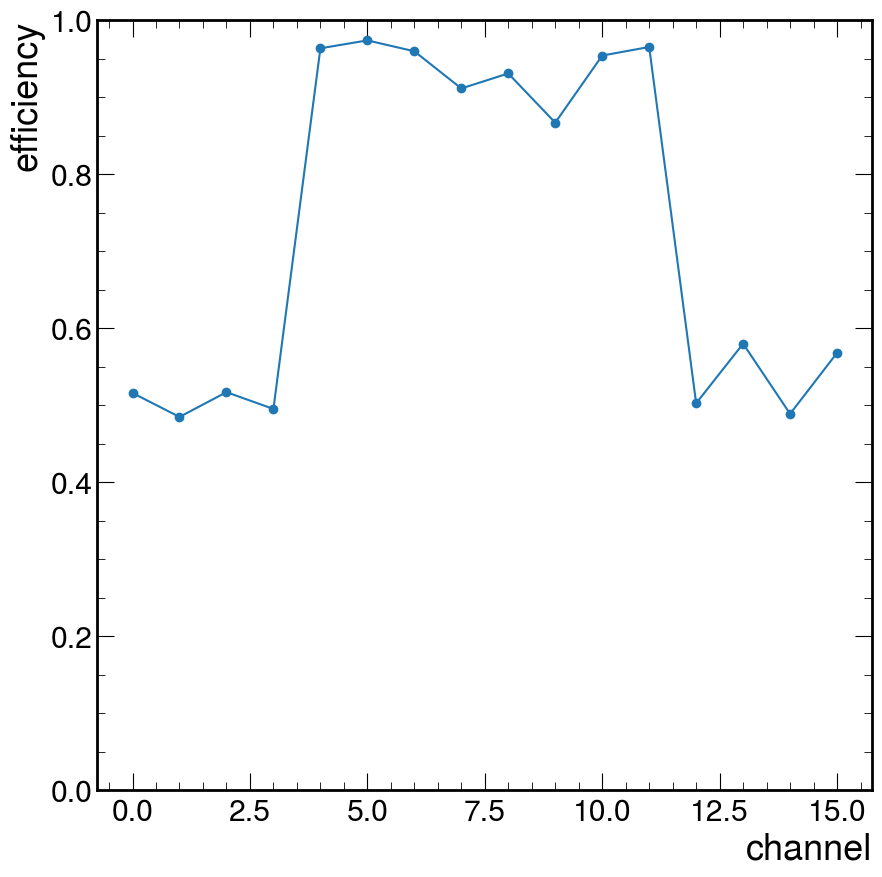

In [29]:
#efficiency plot:
th1=LG_cut
th2=LG_cut

eff=[]
deff=[]
x=[]




#print(swap)
for ch in channels:
    q = "1==1"#start with dummy condition
    for a in channels:
        if abs(int(swap[ch])-int(swap[a]))==4 and ch!=a:
            q+=f" and (Ch_{a}_LG>{th1})"
    #if int(swap[ch])<=3 or int(swap[a])>=12:
    #    for a in channels:
    #        if abs(int(swap[ch])-int(swap[a]))==12:
    #            q+=f" and (Ch_{a}_LG>{th1})"
    q=q.replace("1==1 and ", "")
    print(ch+":   "+q)
    denom = len(df.query(q))
    num = len(df.query(q).query(f"Ch_{ch}_LG>{th2}"))
    eff.append(num/denom)
    deff.append(np.sqrt(num*(denom-num)/denom**3))
    x.append(int(ch))
plt.errorbar(x, eff, deff, marker='o')
plt.xlabel('channel')
plt.ylabel('efficiency')
plt.ylim(0,1)

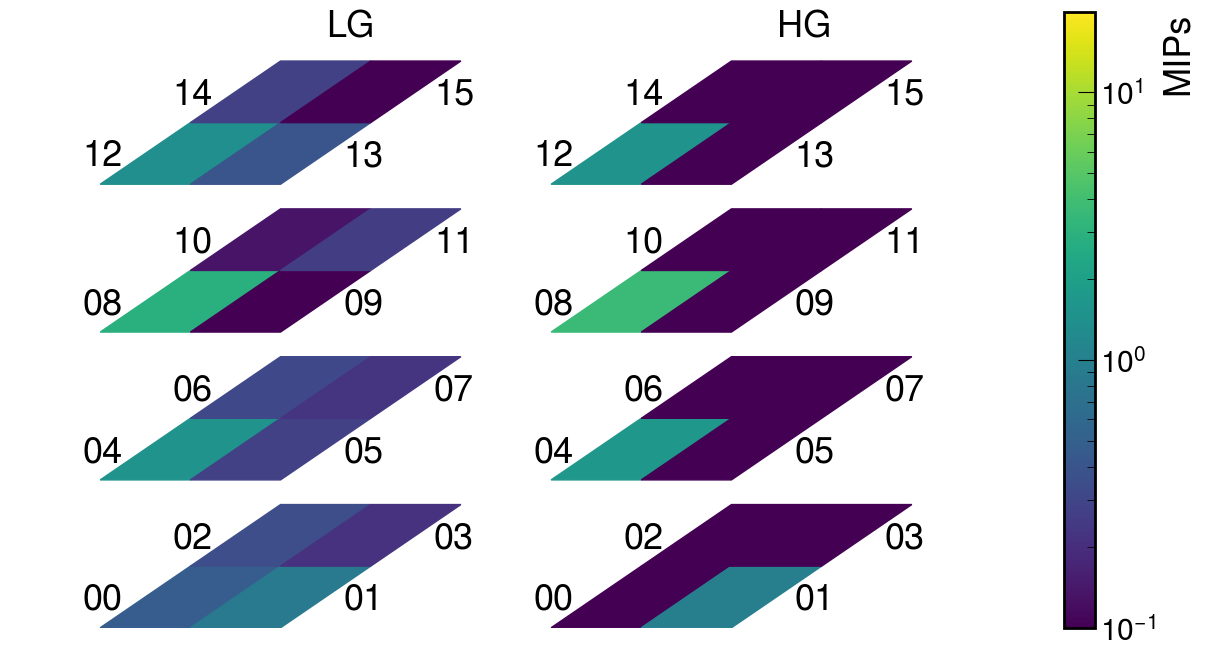

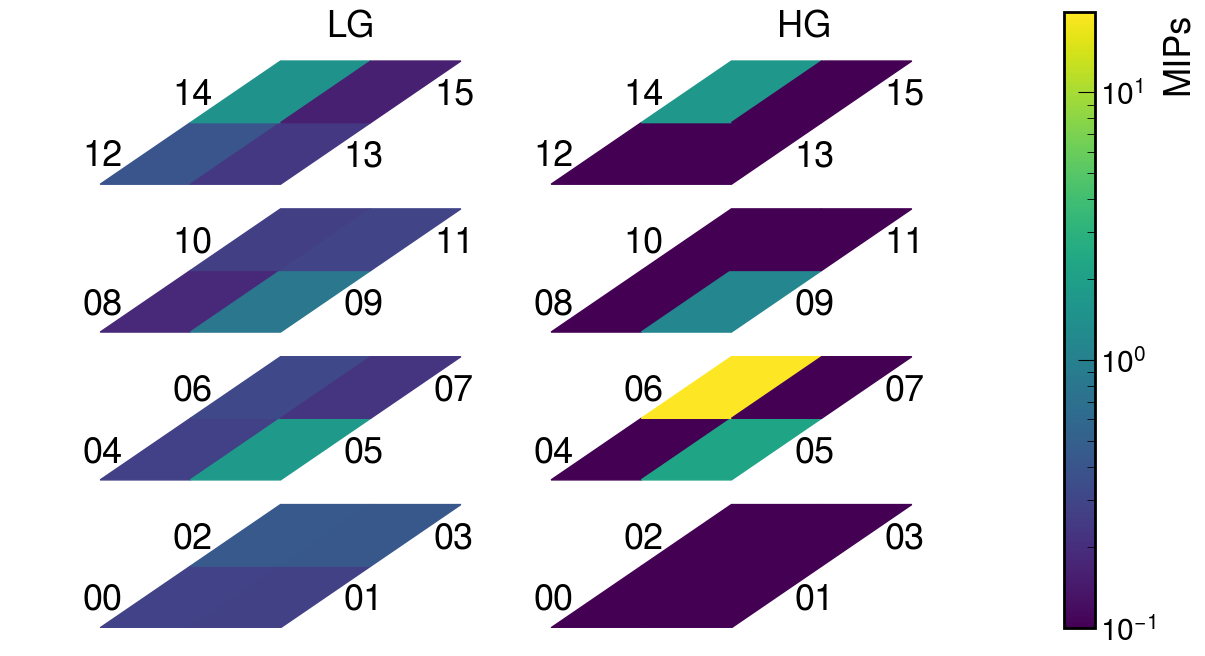

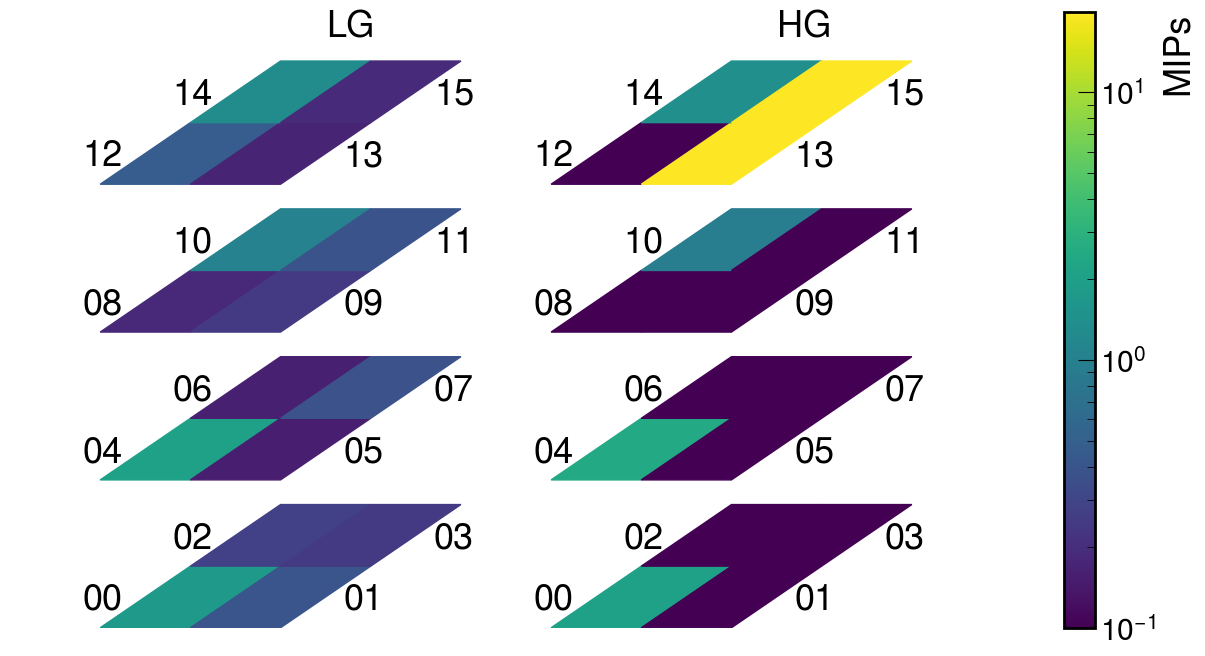

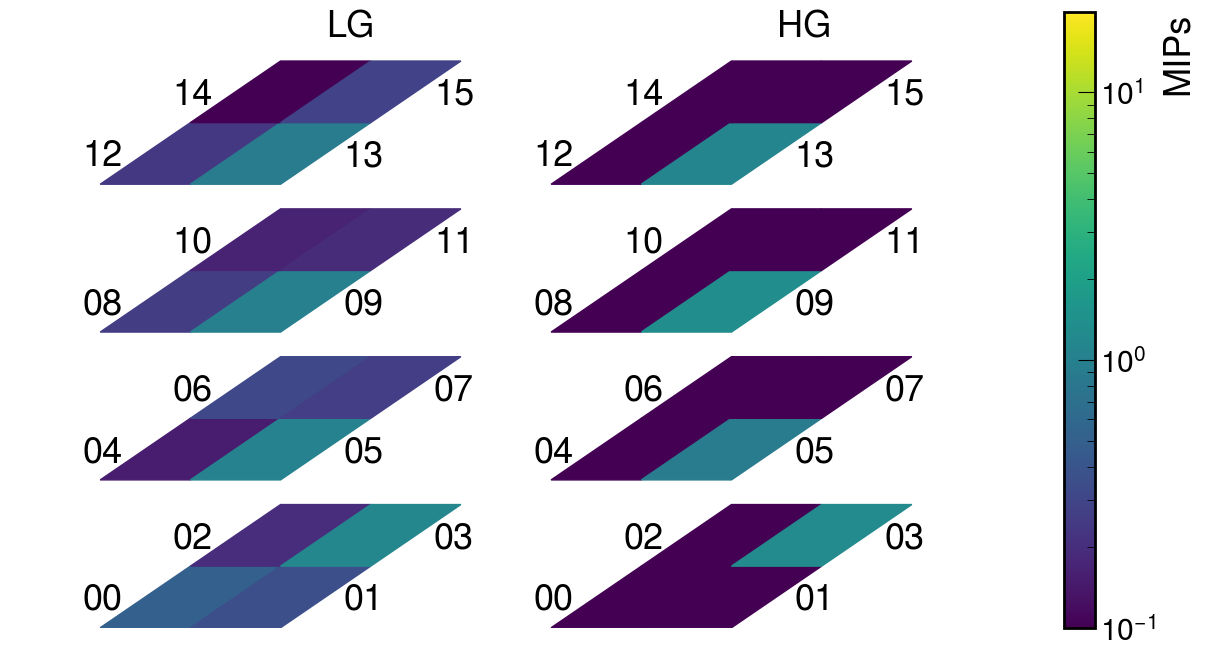

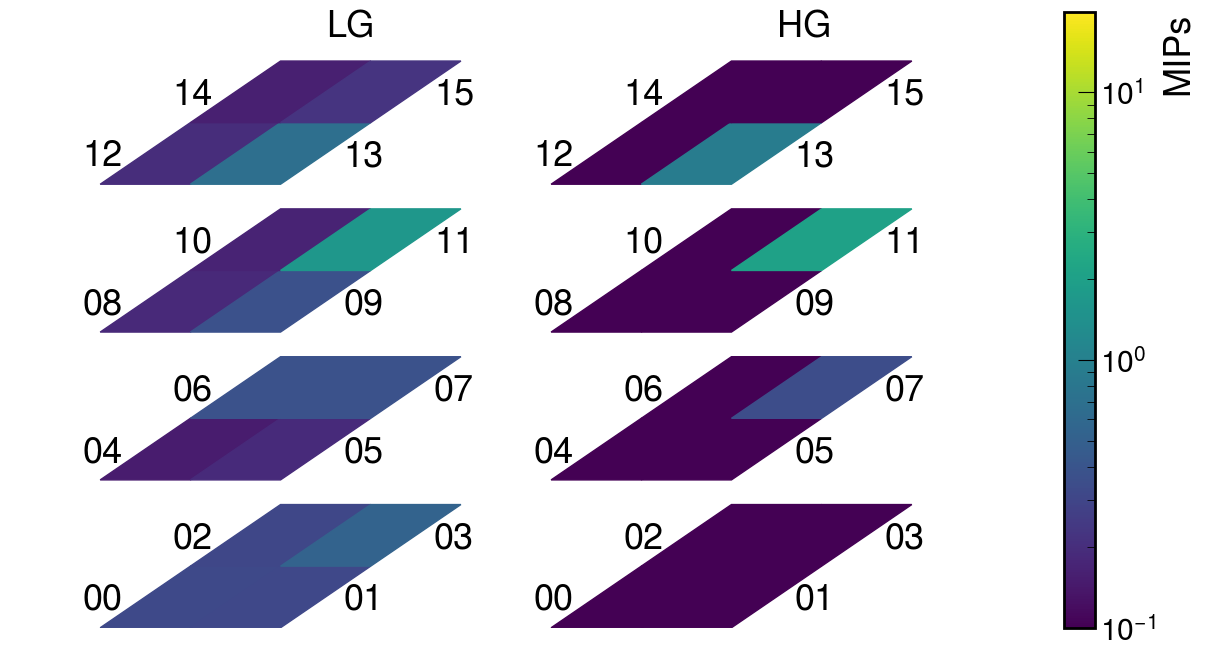

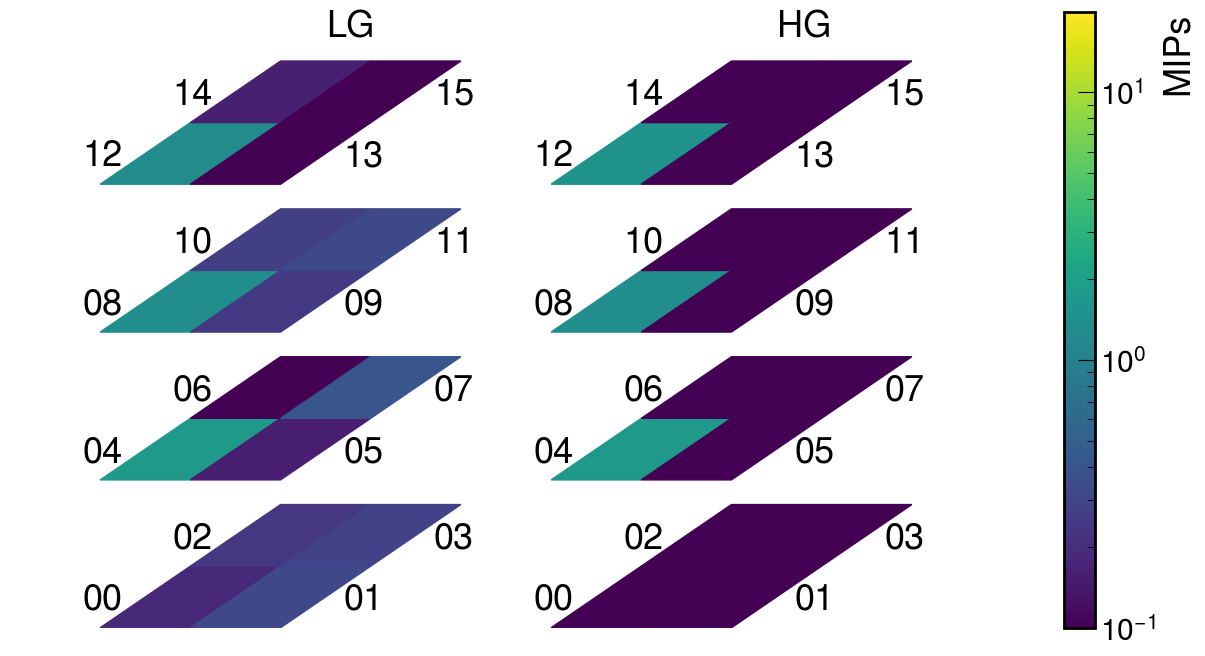

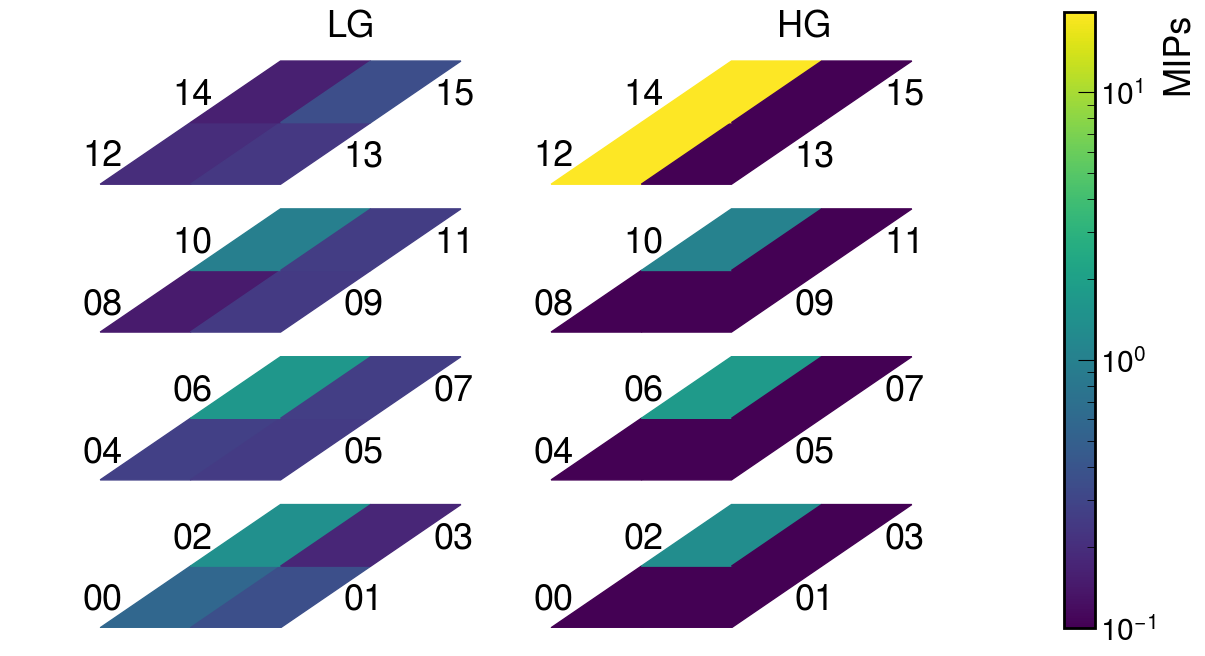

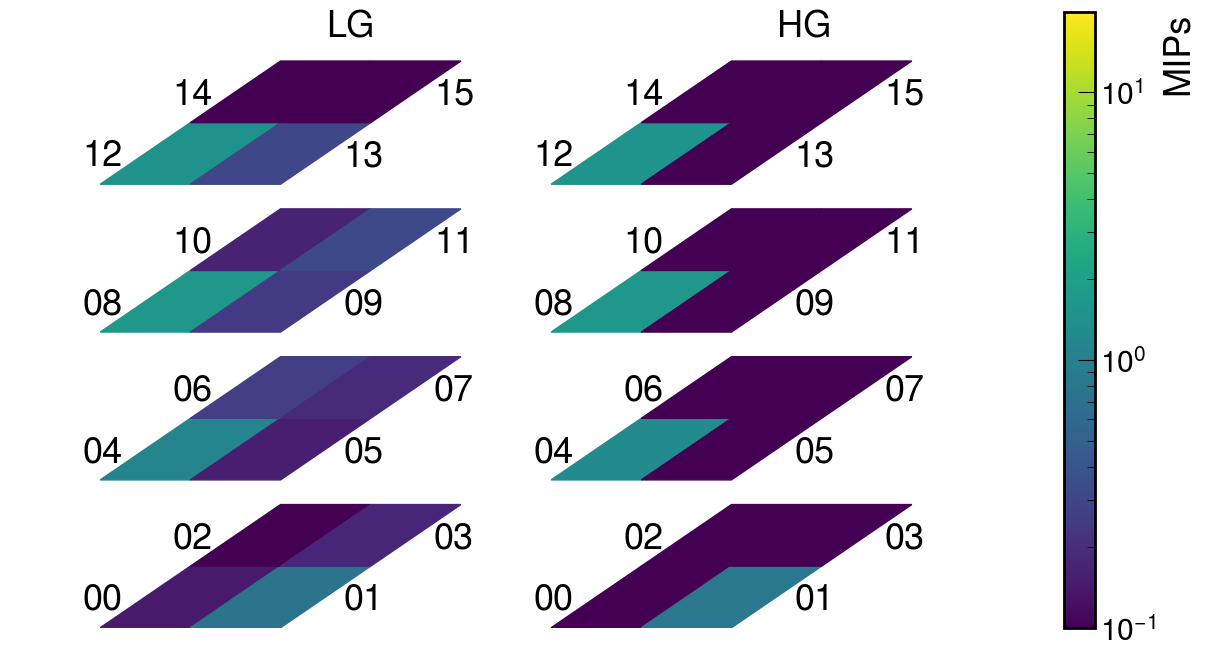

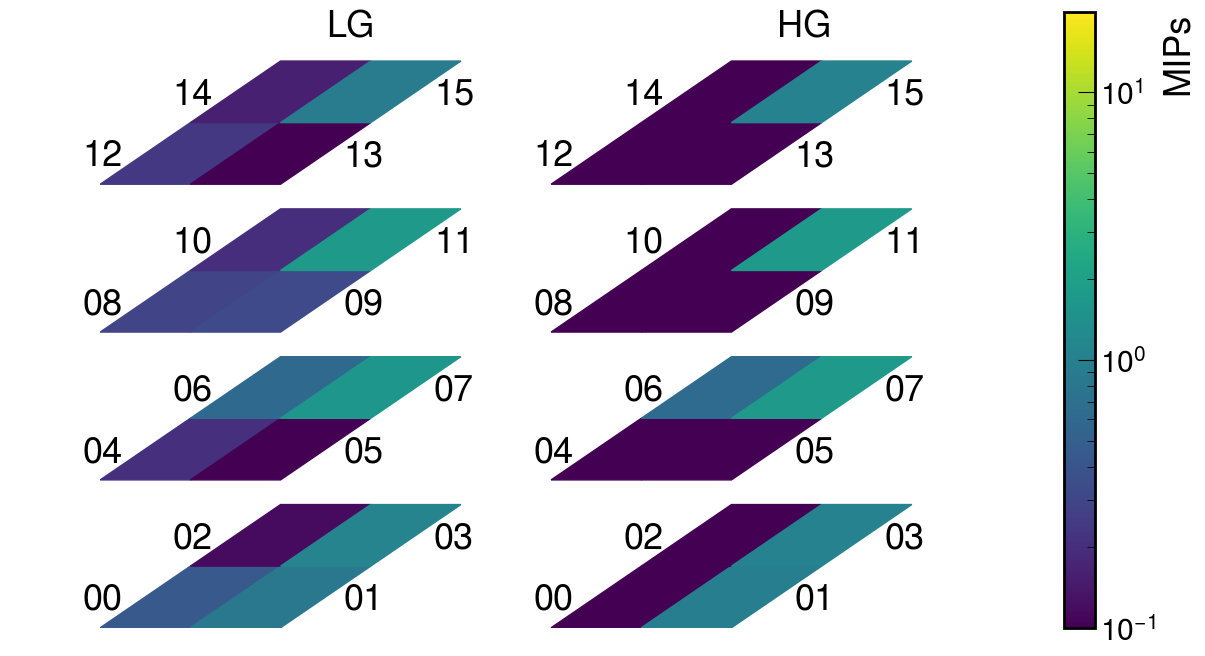

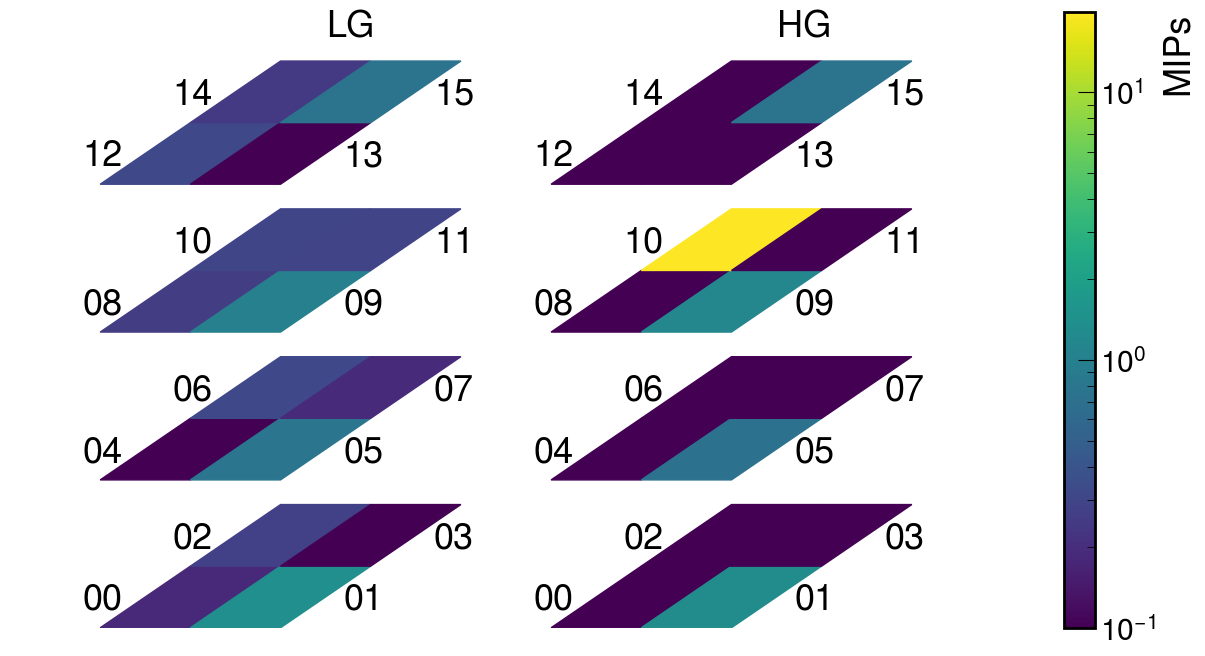

In [34]:
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm



max_val=20
cm= mpl.colormaps['viridis']
norm=LogNorm(0.1,max_val, clip=True)
def event_display(evtn):
    fig,axs= plt.subplots(1,1, figsize=(16, nchannels/2))
    for gain in "LG HG".split():
        for ch in channels:
            a=df[f'Ch_{swap[ch]}_{gain}'][evtn]/MIP[(swap[ch],gain)]
            
            
            #print(a)
            i=int(ch)%2
            j=(int(ch)//2)%2
            k=int(ch)//4
            #print(i, j,k)
            x0=10*i+10*j + 50*(gain=="HG")
            y0=12*k+5*j
            p=plt.Polygon(((x0, y0), (x0+10, y0), (x0+20, y0+5), (x0+10, y0+5)),color=cm(norm(a)))
            plt.text(x0+(19*i)-5+3, y0+1.5, ch)
            plt.gca().add_patch(p)
    plt.xlim(-10, 100)
    plt.ylim(0, 2+12*(nchannels//4))
    plt.axis('off')
    
    plt.text(25, 3*nchannels, "LG")
    plt.text(75, 3*nchannels, "HG")
    plt.colorbar(ScalarMappable(norm), label='MIPs')
    plt.show()

for i in range(10):
    event_display(i)

Text(1, 0, 'Ch_00_LG')

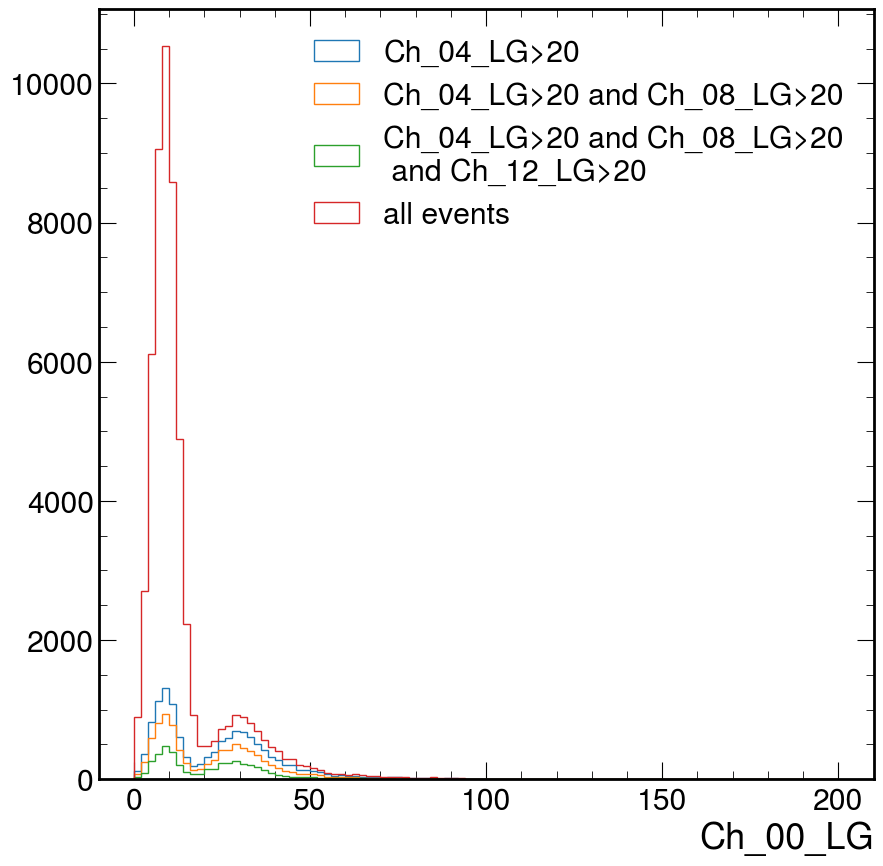

In [33]:
dfq=df.query(f"Ch_04_LG>{LG_cut}")
plt.hist(dfq.Ch_00_LG, bins=100, range=(0,200), label=f"Ch_04_LG>{LG_cut}", histtype='step')
dfq=df.query(f"Ch_04_LG>{LG_cut} and Ch_08_LG>{LG_cut}")
plt.hist(dfq.Ch_00_LG, bins=100, range=(0,200), label=f"Ch_04_LG>{LG_cut} and Ch_08_LG>{LG_cut}", histtype='step')
dfq=df.query(f"Ch_04_LG>{LG_cut} and Ch_08_LG>{LG_cut} and Ch_12_LG>{LG_cut}")
plt.hist(dfq.Ch_00_LG, bins=100, range=(0,200), label=f"Ch_04_LG>{LG_cut} and Ch_08_LG>{LG_cut}\n and Ch_12_LG>{LG_cut}", histtype='step')
plt.hist(df.Ch_00_LG, bins=100, range=(0,200), label="all events", histtype='step')
plt.legend()

plt.xlabel("Ch_00_LG")

In [ ]:
plt.hist(df.Ch_04_LG, histtype='step', bins=100)
plt.hist(df.Ch_04_HG, histtype='step', bins=100)